In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.regression.gmm import IV2SLS

In [47]:
def get_weekday_name(date):
    '''
    date : 'YYYY-MM-DD'
    return : Monday
    '''
    return date.strftime('%A')

# Function to get all days in a time period
def get_all_dates(start_date, end_date):
    delta = end_date - start_date
    return [start_date + timedelta(days=i) for i in range(delta.days + 1)]


# EDA

In [48]:
df = pd.read_csv('./Project3Data.csv')
df['New Unit Price'] = (df['Delivery Fees'] + (df['Unit Price']*df['Quantity Ordered']))/df['Quantity Ordered']
df['Total Price'] = (df['Delivery Fees'] + (df['Unit Price']*df['Quantity Ordered']))/df['Quantity Ordered']
# df = df.dropna()
df.head()

df.to_excel('Project3Data_W_newpricing.xlsx')

- check week day name

In [49]:
# check if we have every week day evenly -> no (sunday data is very few)
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df['dow'] = df.Date.apply(lambda x: get_weekday_name(x))
df['dow'].value_counts() 

dow
Sunday       72
Monday       68
Tuesday      68
Wednesday    68
Thursday     68
Friday       68
Saturday     68
Name: count, dtype: int64

- check dataset

In [50]:
# discount applied date
df[['Region','Discount Applied','Date']].groupby(['Region','Discount Applied']).agg({'Date':'min'})

Date
Region Discount Applied           
1      0                2023-01-01
2      0                2023-01-01
3      0                2023-01-01
       1                2023-03-01
4      0                2023-01-01
       1                2023-03-01

In [51]:
# unique values
df[['Region','New Unit Price','Distance','Delivery Fees','Discount Applied']].drop_duplicates().sort_values(by=['Region','Distance'])

,Region,New Unit Price,Distance,Delivery Fees,Discount Applied
0,1,16.047619,2,1.000,0
4,1,16.050000,2,1.000,0
8,1,16.045455,2,1.000,0
20,1,16.052632,2,1.000,0
24,1,16.055556,2,1.000,0
...,...,...,...,...,...
335,4,17.781250,15,7.125,1
339,4,17.017857,15,7.125,1
347,4,17.187500,15,7.125,1
467,4,17.425000,15,7.125,1


# Plot Average

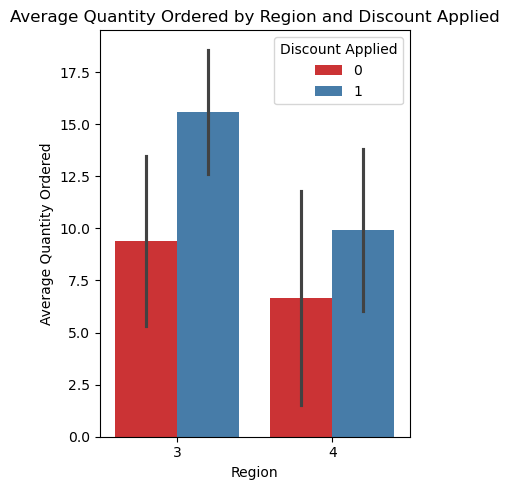

In [52]:
plt.figure(figsize=(4, 5))
sns.barplot(
    data=df[df.Region.isin([3,4])],
    x='Region',
    y='Quantity Ordered',
    hue='Discount Applied',
    errorbar='sd',  # std bar
    palette='Set1'
)

# title, label
plt.xlabel('Region')
plt.ylabel('Average Quantity Ordered')
plt.title('Average Quantity Ordered by Region and Discount Applied')
plt.legend(title='Discount Applied')

plt.tight_layout()
plt.show()

# DID plot

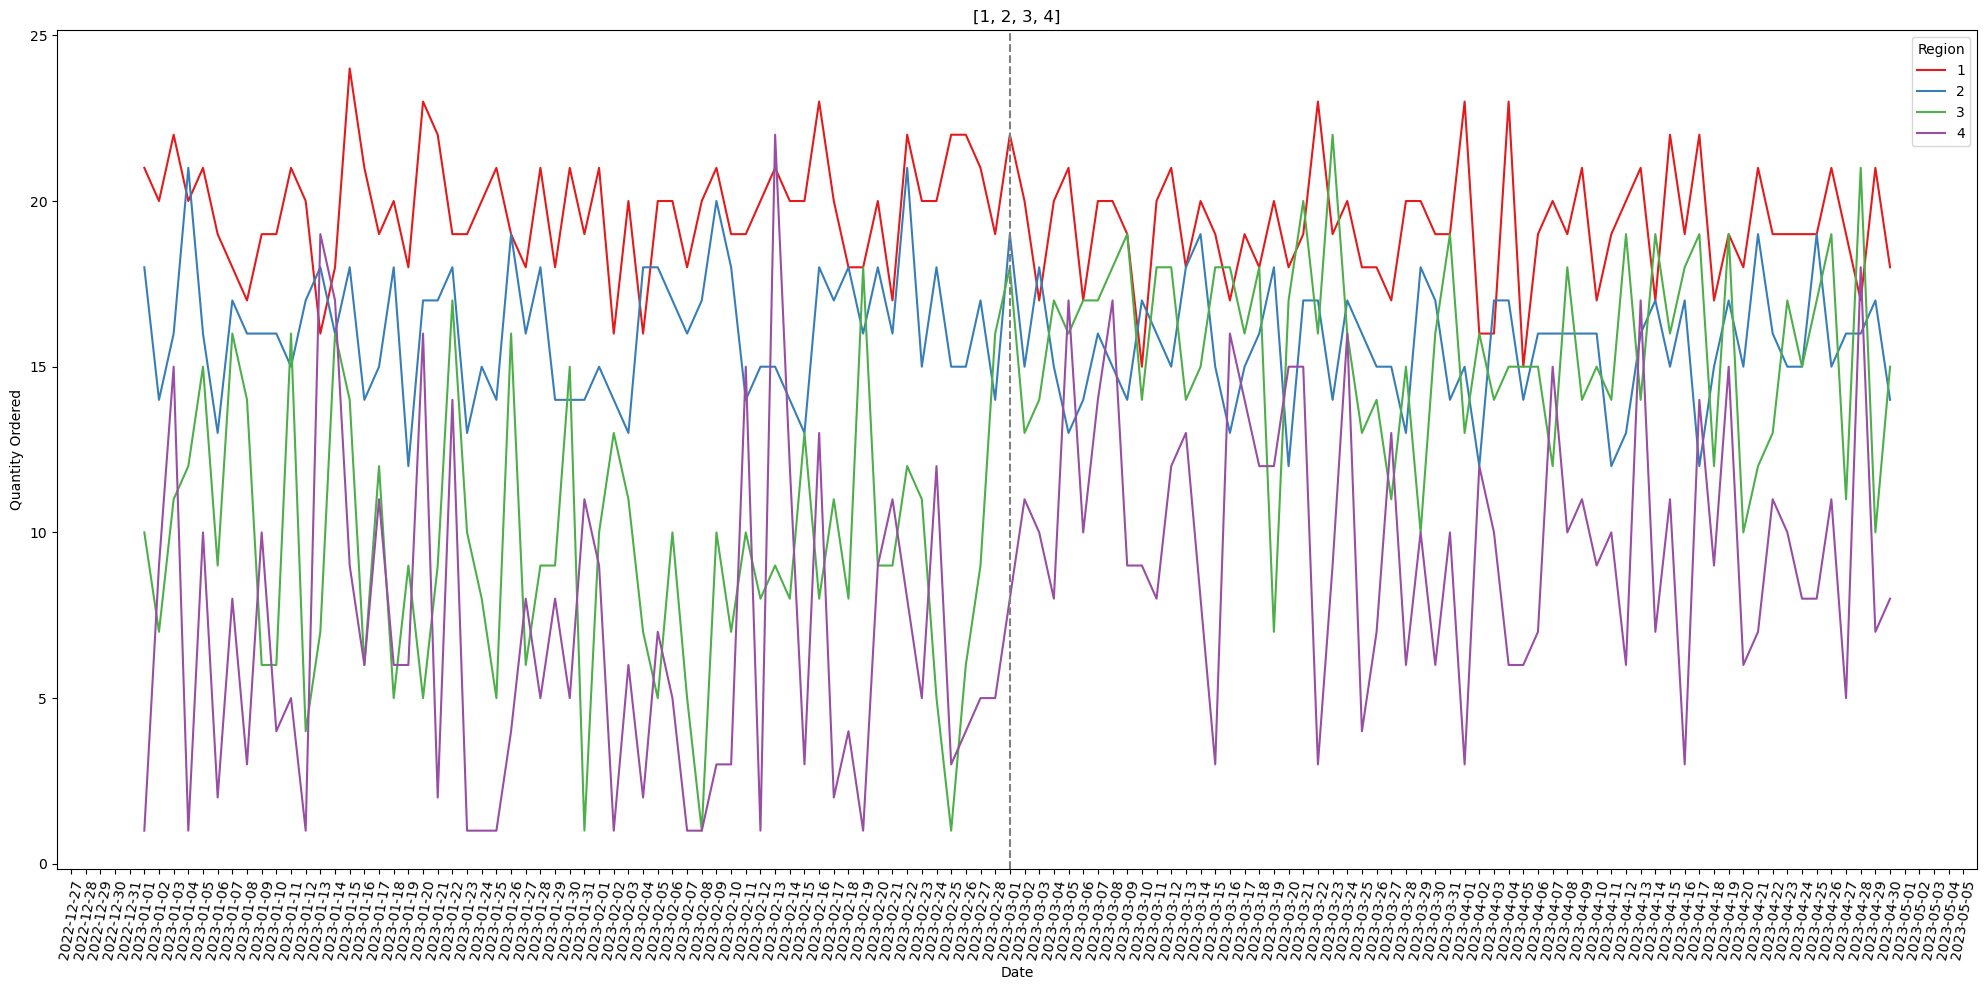

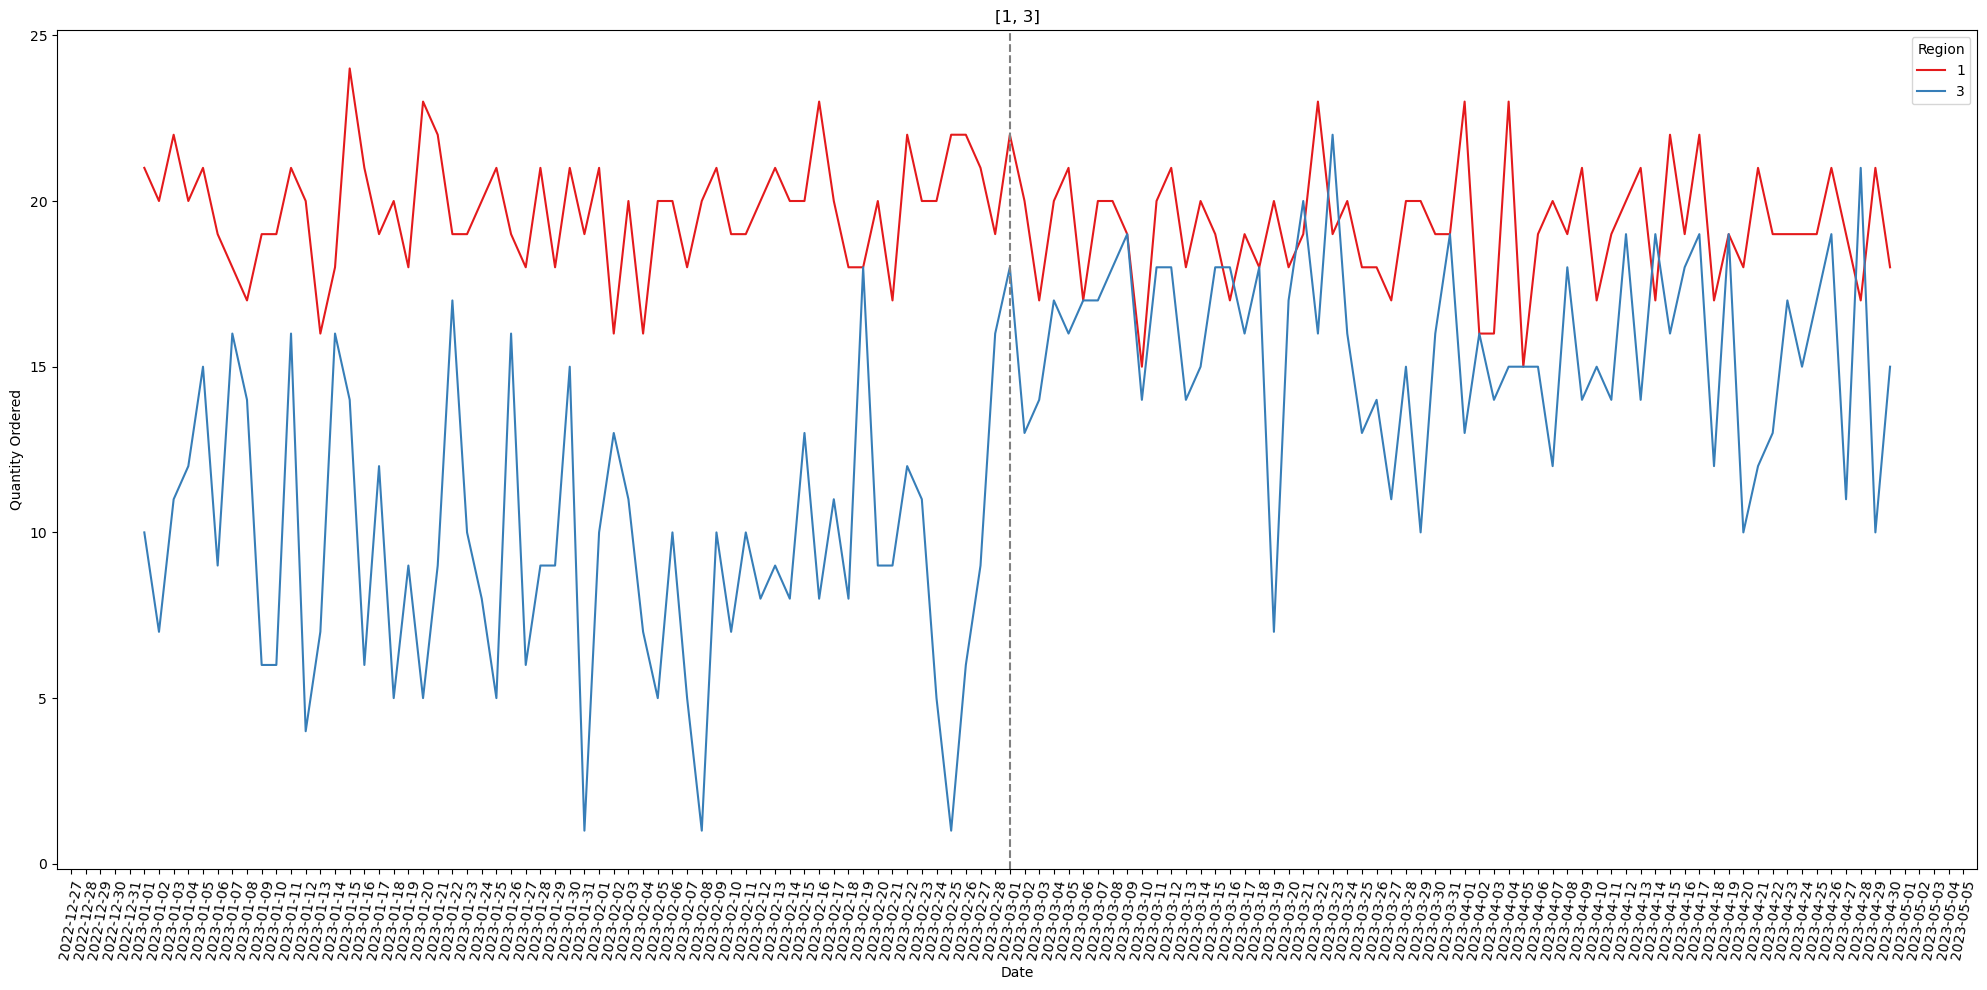

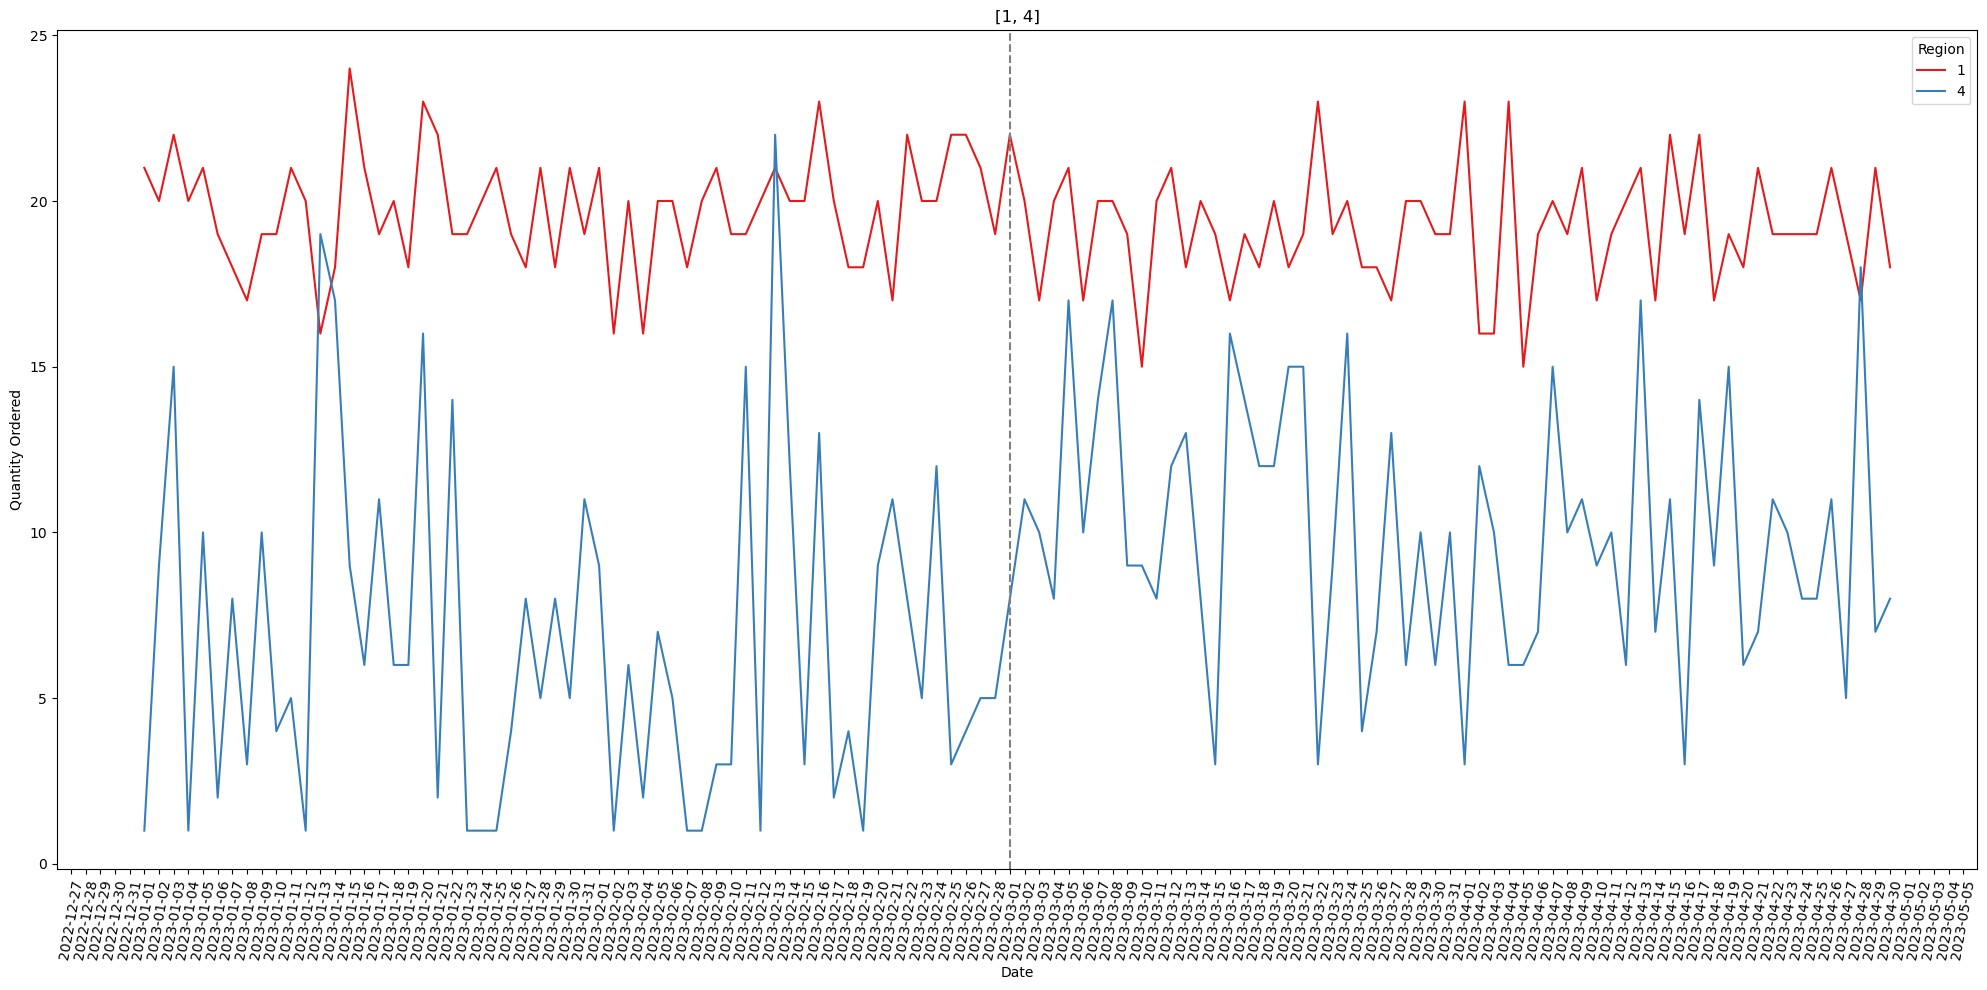

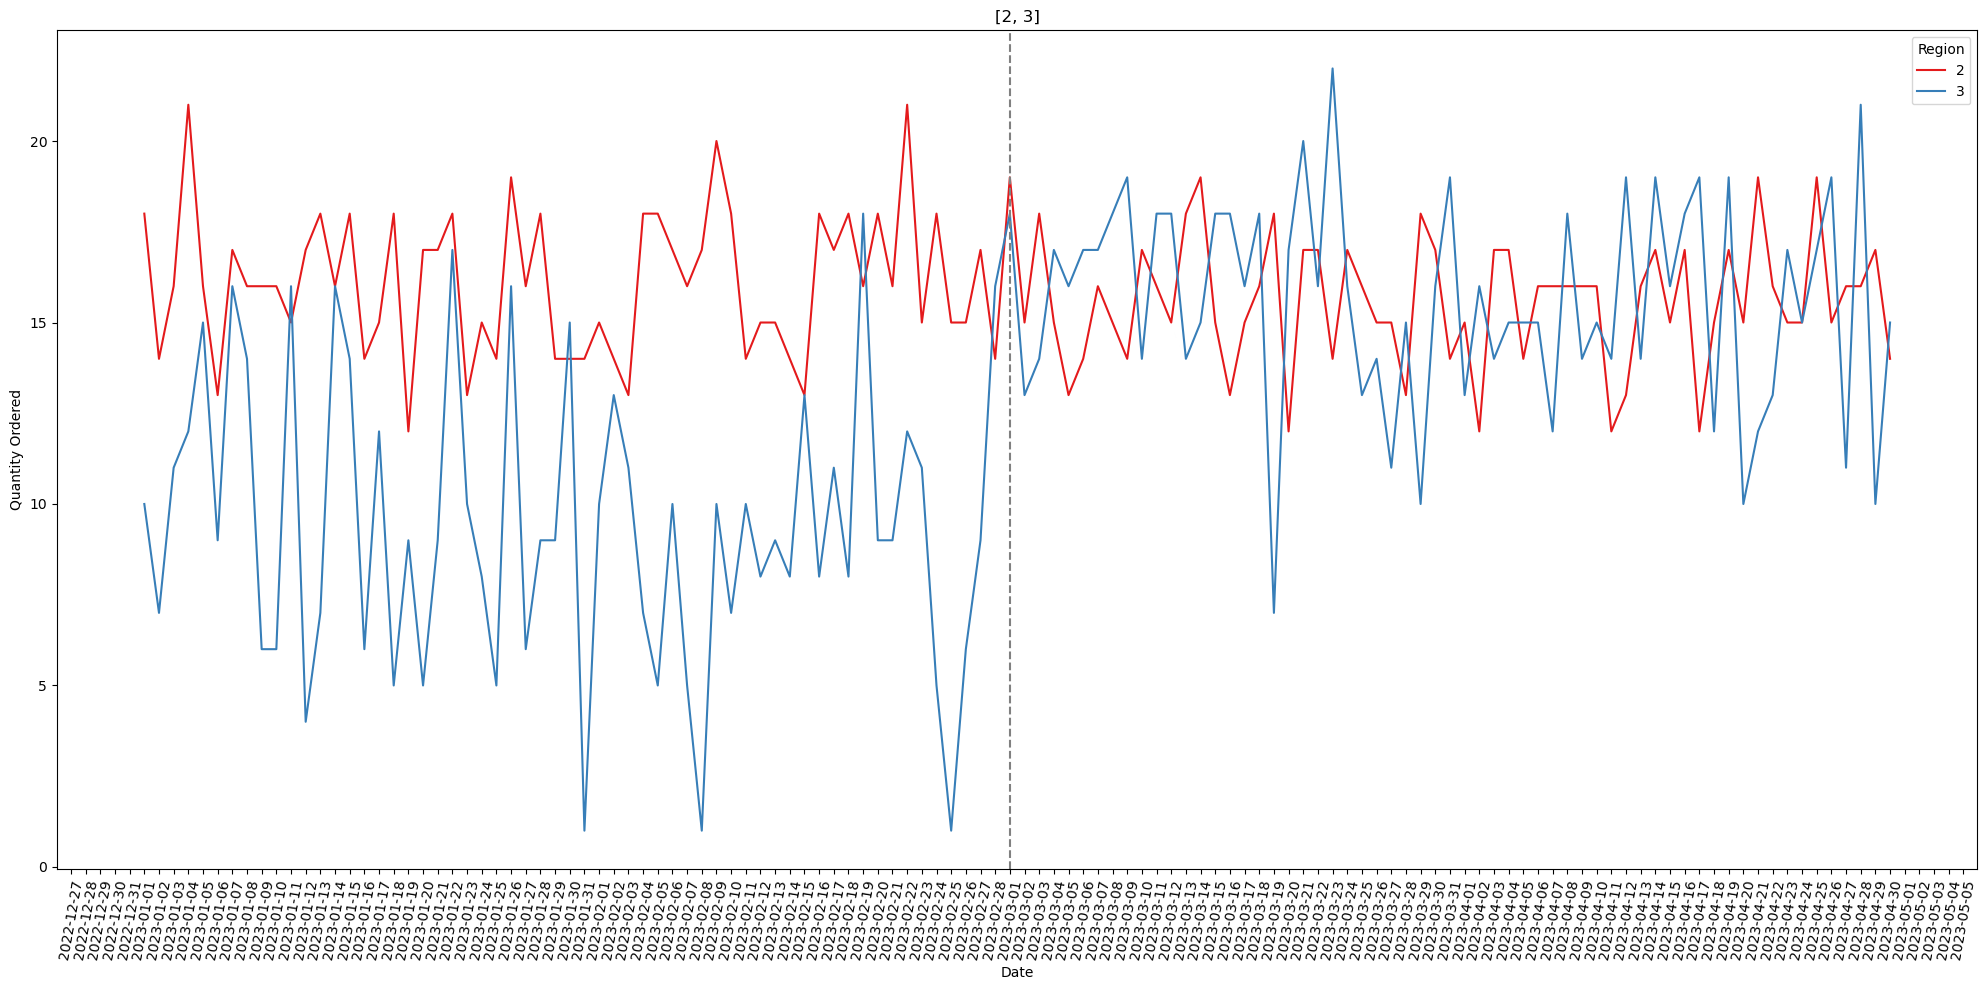

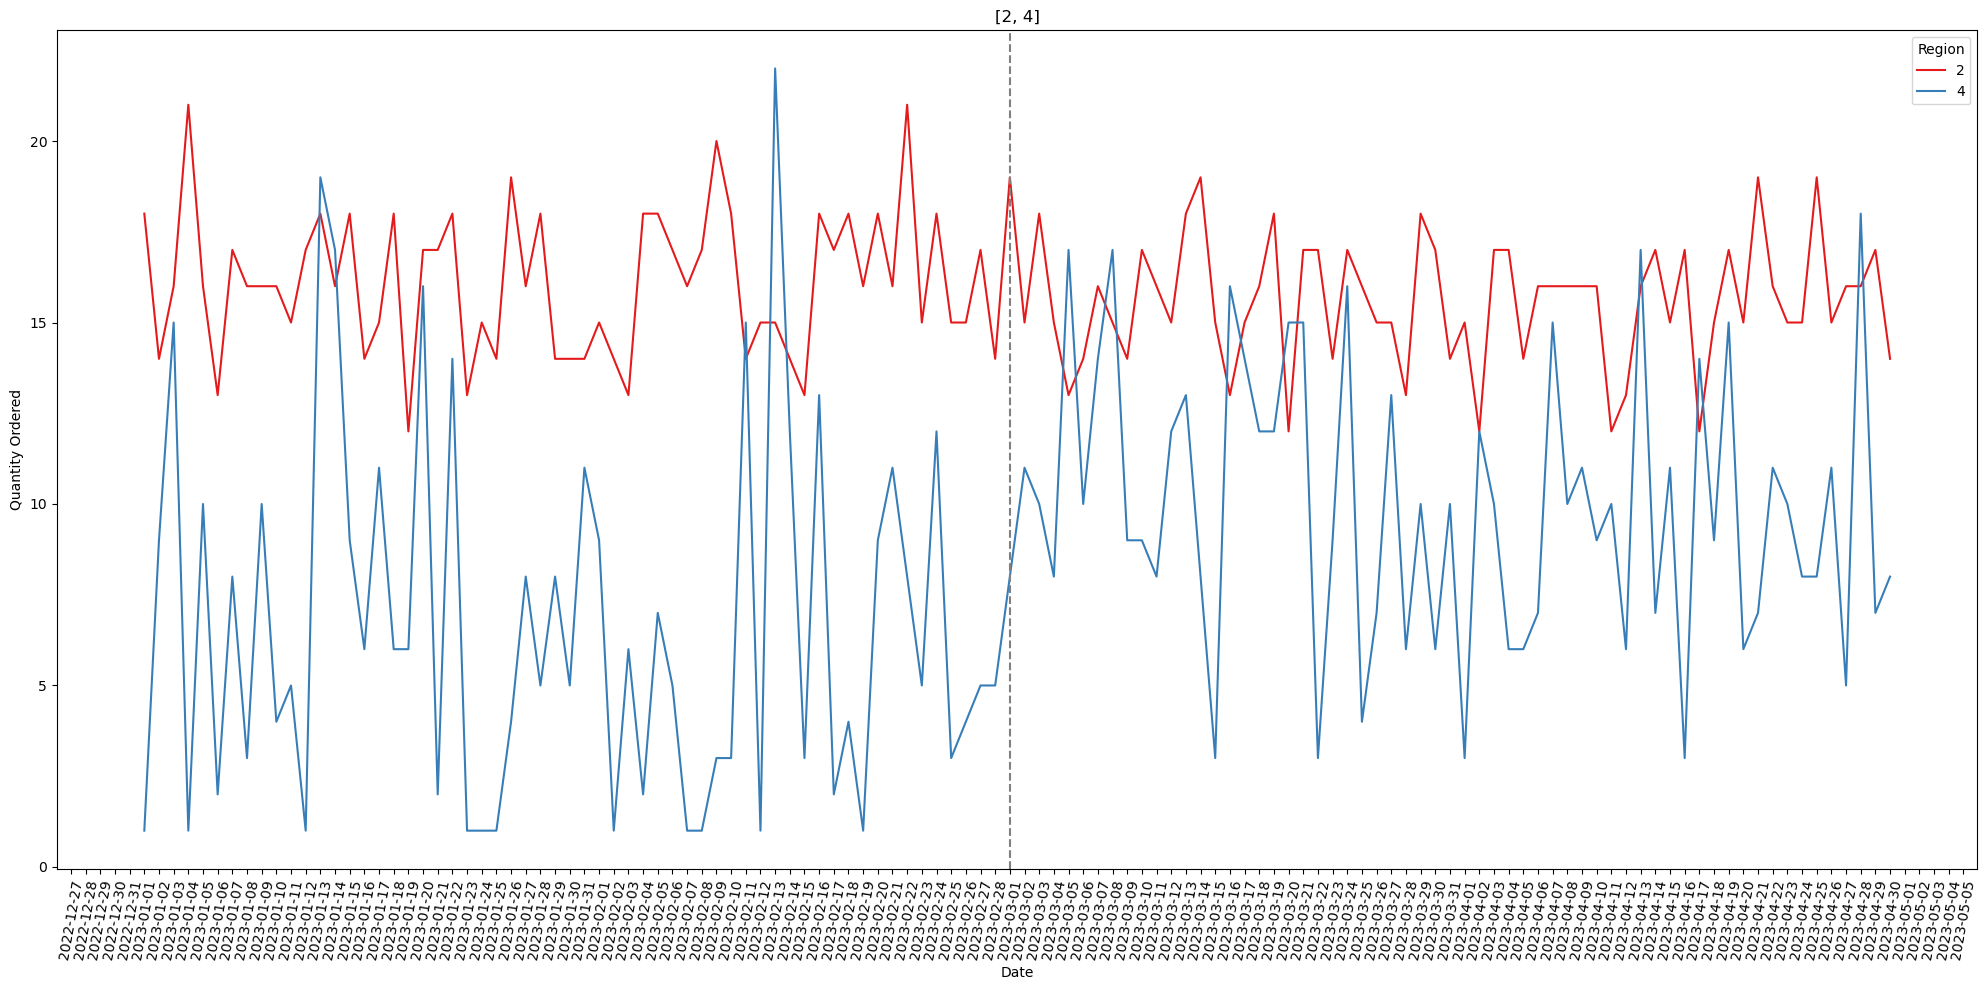

In [53]:
# plot
region_combination = [[1,2,3,4],[1,3],[1,4],[2,3],[2,4]]

for i, region in enumerate(region_combination):
    plt.figure(figsize=(20, 10))
    subset = df[df['Region'].isin(region)]
    sns.lineplot(data=subset, x='Date',y='Quantity Ordered', hue='Region', palette='Set1')

    # discount applied date
    phase_2_start = datetime(2023,3,1)
    plt.axvline(x=phase_2_start, color='grey', linestyle='--', label='Phase 2 Start')

    # x axis date format
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # everyday
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # dateformat

    plt.title(f'{region}')    
    plt.xticks(rotation=80)
    plt.tight_layout()
    plt.show()

# regression
y = a + (b1 x region) + (b2 x discount) + (b3 x region x discount) + e

In [54]:
# region 2 vs 3
target = df[df['Region'].isin([2,3])].drop(columns='dow')
target['Treatment'] = target['Region'].apply(lambda x: 0 if x==2 else 1)
# target['Total Price'] = df['Delivery Fees'] + df['Unit Price']
target['Post'] = target['Date'].apply(lambda x: 1 if x >= datetime(2023,3,1) else 0)
target['Treatment_Post'] = target['Treatment']*target['Post']
target.head()

# region 1 vs 3
# target = df[df['Region'].isin([1,3])].drop(columns='dow')
# target['Region'] = target['Region'].apply(lambda x: 0 if x==1 else 1)
# target['region_discount'] = target['Region']*target['Discount Applied']
# target.head()

,Date,Region,Unit Price,Quantity Ordered,Distance,Delivery Fees,Discount Applied,New Unit Price,Total Price,Treatment,Post,Treatment_Post
1,2023-01-01,2,16.0,18,5,2.5,0,16.138889,16.138889,0,0,0
2,2023-01-01,3,16.0,10,9,4.5,0,16.450000,16.450000,1,0,0
5,2023-01-02,2,16.0,14,5,2.5,0,16.178571,16.178571,0,0,0
6,2023-01-02,3,16.0,7,9,4.5,0,16.642857,16.642857,1,0,0
9,2023-01-03,2,16.0,16,5,2.5,0,16.156250,16.156250,0,0,0


In [55]:
# OLS
y=target['Quantity Ordered']
X=target[['Treatment','Post','Treatment_Post']]
# X['Date'] = X['Date'].apply(lambda x: int(datetime.strftime(x,'%Y%m%d')))
X = sm.add_constant(X)
model = sm.OLS(endog=y, exog=X).fit()
#print(model.summary())
print("Region 2 vs 3")
model.summary()

Region 2 vs 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Quantity Ordered   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     73.87
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           1.00e-33
Time:                        18:41:54   Log-Likelihood:                -590.39
No. Observations:                 240   AIC:                             1189.
Df Residuals:                     236   BIC:                             1203.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.1017      0.372     43.306      0.000      15.369      16.834
Treatment         -6.6949      0.526    -12.732      0.000      -7.731      -5.659
Post              -0.4951      0.521     -0.949      0.343      -1.523       0.532
Treatment_Post     6.6785      0.738      9.056      0.000       5.226       8.131
==============================================================================
Omnibus:                        4.789   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                6.533
Skew:                          -0.018   Prob(JB):                       0.0381
Kurtosis:                       3.807   Cond. No.                         6.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


--- Check Linear Regression Assumptions ---


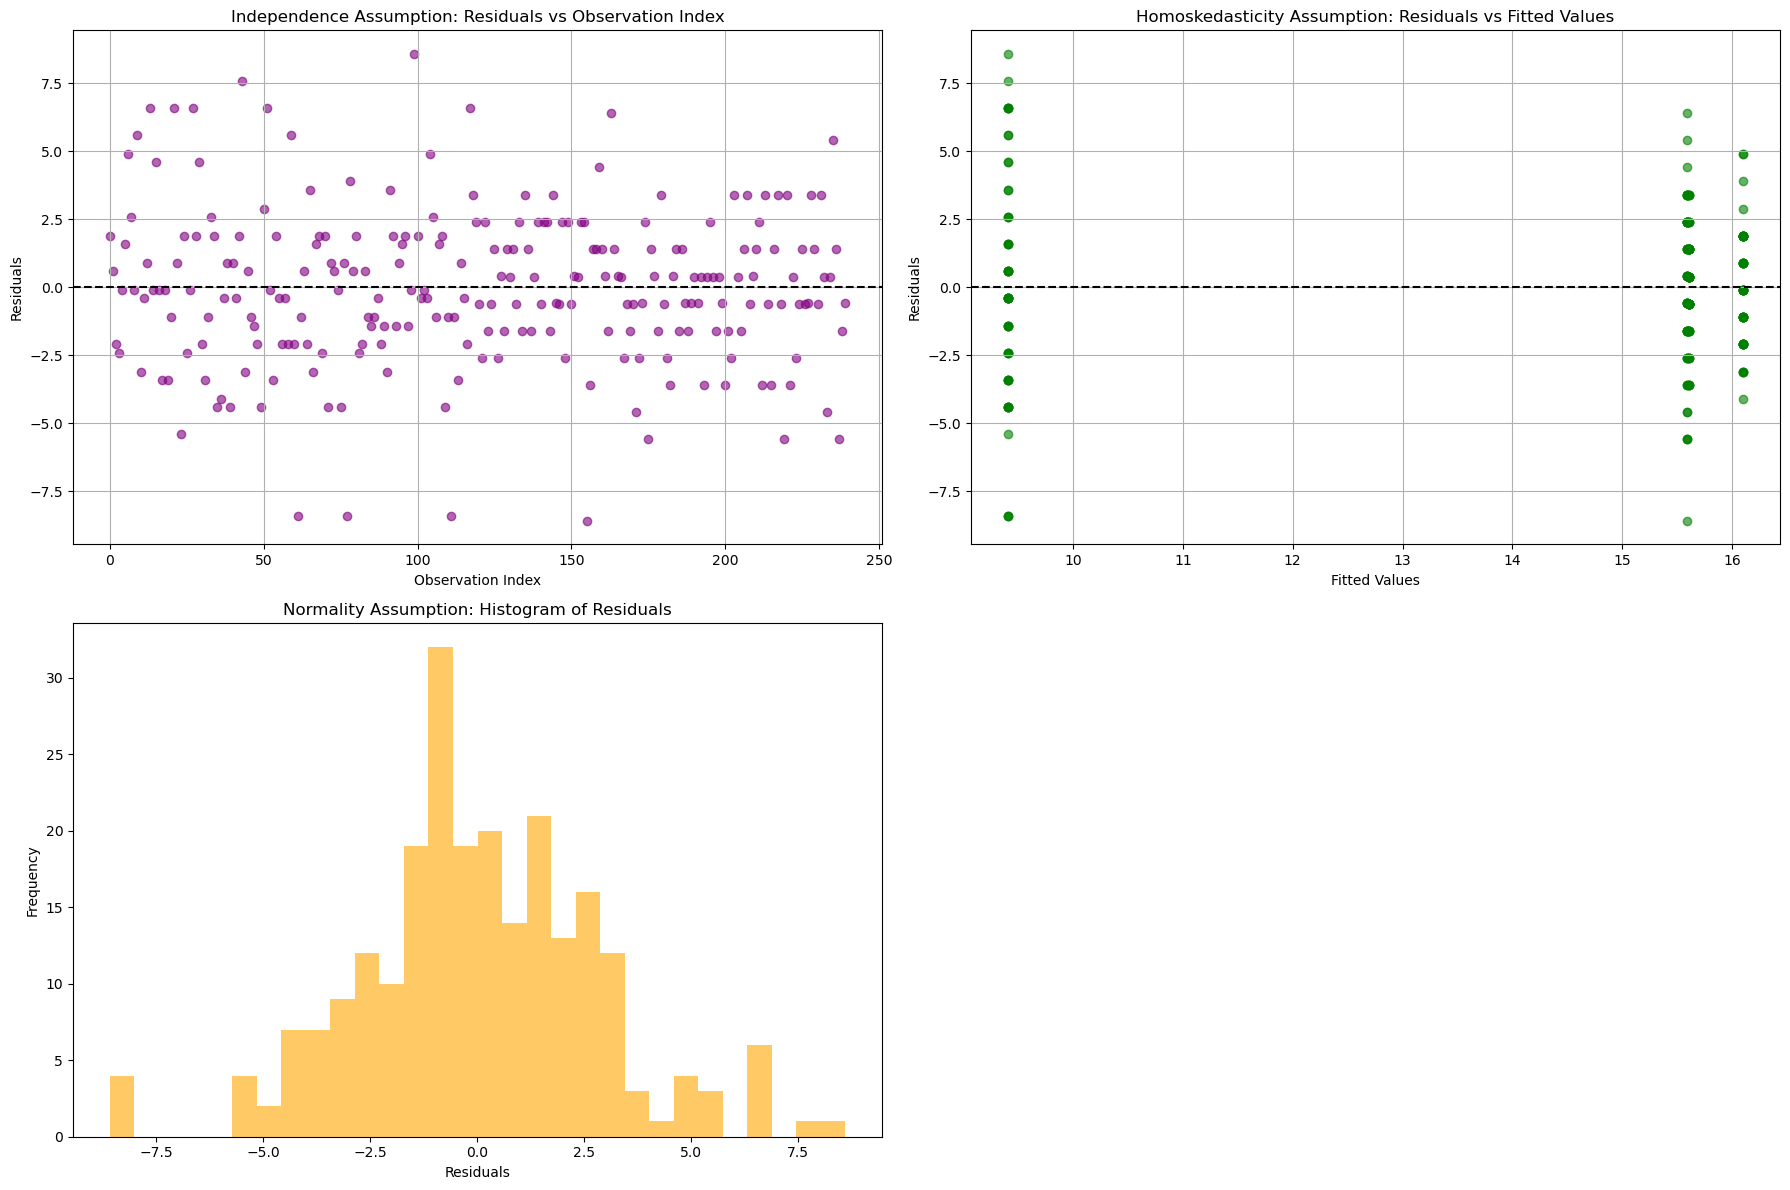


--- Multicollinearity Check (Variance Inflation Factor) ---
          Feature       VIF
1       Treatment  2.033898
2            Post  2.000000
3  Treatment_Post  3.033898


In [56]:
# Fit a simple linear regression model
residuals = model.resid
fitted_values = model.fittedvalues  

plt.figure(figsize=(18, 12))
print("\n--- Check Linear Regression Assumptions ---")

# 1. Independence (Scatter plot of residuals vs observation index)
plt.subplot(2, 2, 1)
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Independence Assumption: Residuals vs Observation Index')
plt.xlabel('Observation Index')
plt.ylabel('Residuals')
plt.grid(True)

# 2. Homoskedasticity (Residuals vs Fitted Values)
plt.subplot(2, 2, 2)
plt.scatter(fitted_values, residuals, color='green', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Homoskedasticity Assumption: Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)

# 3. Normality of Residuals (Histogram)
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, color='orange', alpha=0.6)
plt.title('Normality Assumption: Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Multicollinearity Check
print("\n--- Multicollinearity Check (Variance Inflation Factor) ---")

# Calculating VIF for each independent variable (excluding the constant)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Exclude the constant (intercept) from the VIF results
vif_data = vif_data[vif_data["Feature"] != "const"]
print(vif_data)

<h3>Use the slope to get the best fit and pass through average</h3>
<p>For a 5% change in price, the quantity demanded changes by 3.09 units</p>

In [57]:
m = model.params.iloc[3]
m

6.678521811614359

<p>Now we use the average of the clusters and pass the line through using the elasticity</p>

In [58]:
df_region_3 = target[(target['Region'] == 1)]
df_region_3_pre = target.loc[(target['Region'] == 1) & (df['Unit Price'] == 15.2)]
df_region_3_post = target.loc[(target['Region'] == 1) & (df['Unit Price'] == 16)]

mean_of_discount_pre = df_region_3_pre.describe().loc['mean', 'Quantity Ordered']
mean_of_discount_post = df_region_3_post.describe().loc['mean', 'Quantity Ordered']

<p>To get slope, we need (change in price)/ (change in qty)</p>

In [59]:
# df_reg3_pretreatment = target[(target['Region'] == 1) & (df['Unit Price'] == 16)]
# mean_of_df3_pretreatment = df_reg3_pretreatment.describe().loc['mean', 'Quantity Ordered']
# print(mean_of_df3_pretreatment)

# elasticity = (m/mean_of_df3_pretreatment)/(-5/100)

elasticity = m/(15.2-16)

elasticity

-8.34815226451794

6.678521811614359
-8.34815226451794
nan


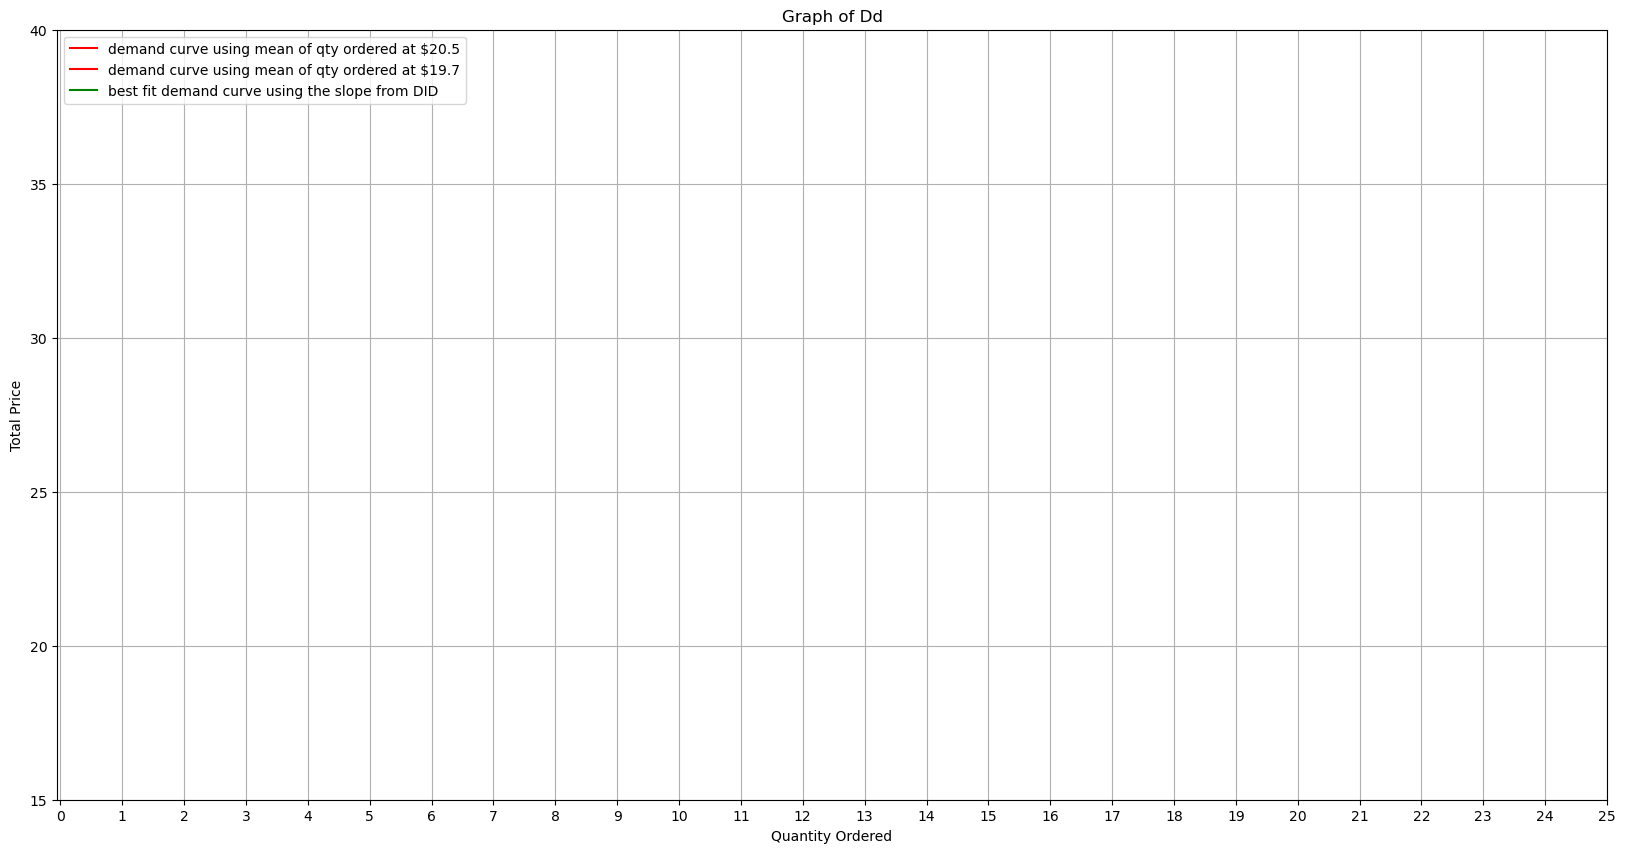

In [60]:
print(m)
print(elasticity)
intercept_1 = elasticity*(mean_of_discount_pre*-1)+20.5
intercept_2 = elasticity*(mean_of_discount_post*-1)+19.7

x = np.arange(0, 26, 1)
y_16 = elasticity*x+intercept_1
y_discount = elasticity*x+intercept_2
best_fit = elasticity*x+((intercept_1+intercept_2)/2)
print((intercept_1+intercept_2)/2)
plt.figure(figsize=(20, 10))
plt.plot(x, y_16, '-r', label='demand curve using mean of qty ordered at $20.5')
plt.plot(x, y_discount, '-r', label='demand curve using mean of qty ordered at $19.7')
plt.plot(x, best_fit, '-g', label='best fit demand curve using the slope from DID')
# plt.scatter(df_region_2['Quantity Ordered'], df_region_2['Total Price'])
plt.scatter(df_region_3['Quantity Ordered'], df_region_3['Total Price'])
plt.ylim(15,40)
plt.title('Graph of Dd')
plt.xlabel('Quantity Ordered')
plt.ylabel('Total Price')
plt.legend(loc='upper left')
plt.xticks(np.arange(0, 26, 1))  # Set x-ticks from 0 to 25 with a step of 1
plt.grid()
plt.show()

<h3>Do the same for region 4 against region 2 to see if the demand is the same</h3>

In [61]:
# region 2 vs 4
target = df[df['Region'].isin([2,4])]
target['Treatment'] = target['Region'].apply(lambda x: 0 if x==2 else 1)
target['Post'] = target['Date'].apply(lambda x: 1 if x >= datetime(2023,3,1) else 0)
target['Treatment_Post'] = target['Treatment']*target['Post']
target.head()

# region 1 vs 3
# target = df[df['Region'].isin([1,3])].drop(columns='dow')
# target['Region'] = target['Region'].apply(lambda x: 0 if x==1 else 1)
# target['region_discount'] = target['Region']*target['Discount Applied']
# target.head()

print("Region 2 vs 4")
# OLS
y=target['Quantity Ordered']
X=target[['Treatment','Post','Treatment_Post']]
# X['Date'] = X['Date'].apply(lambda x: int(datetime.strftime(x,'%Y%m%d')))
X = sm.add_constant(X)
model = sm.OLS(endog=y, exog=X).fit()
model.summary()

Region 2 vs 4


/var/folders/pw/_ml9mkrn07v5x0fngqp4qhg00000gn/T/ipykernel_1512/107212361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['Treatment'] = target['Region'].apply(lambda x: 0 if x==2 else 1)
/var/folders/pw/_ml9mkrn07v5x0fngqp4qhg00000gn/T/ipykernel_1512/107212361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['Post'] = target['Date'].apply(lambda x: 1 if x >= datetime(2023,3,1) else 0)
/var/folders/pw/_ml9mkrn07v5x0fngqp4qhg00000gn/T/ipykernel_1512/107212361.py:5: SettingWithCopyWarning

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Quantity Ordered   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     102.8
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           1.39e-42
Time:                        18:41:54   Log-Likelihood:                -638.07
No. Observations:                 240   AIC:                             1284.
Df Residuals:                     236   BIC:                             1298.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.1017      0.454     35.503      0.000      15.208      16.995
Treatment         -9.4576      0.641    -14.745      0.000     -10.721      -8.194
Post              -0.4951      0.636     -0.778      0.437      -1.748       0.758
Treatment_Post     3.7691      0.900      4.190      0.000       1.997       5.541
==============================================================================
Omnibus:                       35.084   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.358
Skew:                           0.807   Prob(JB):                     1.29e-13
Kurtosis:                       4.825   Cond. No.                         6.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


--- Check Linear Regression Assumptions ---


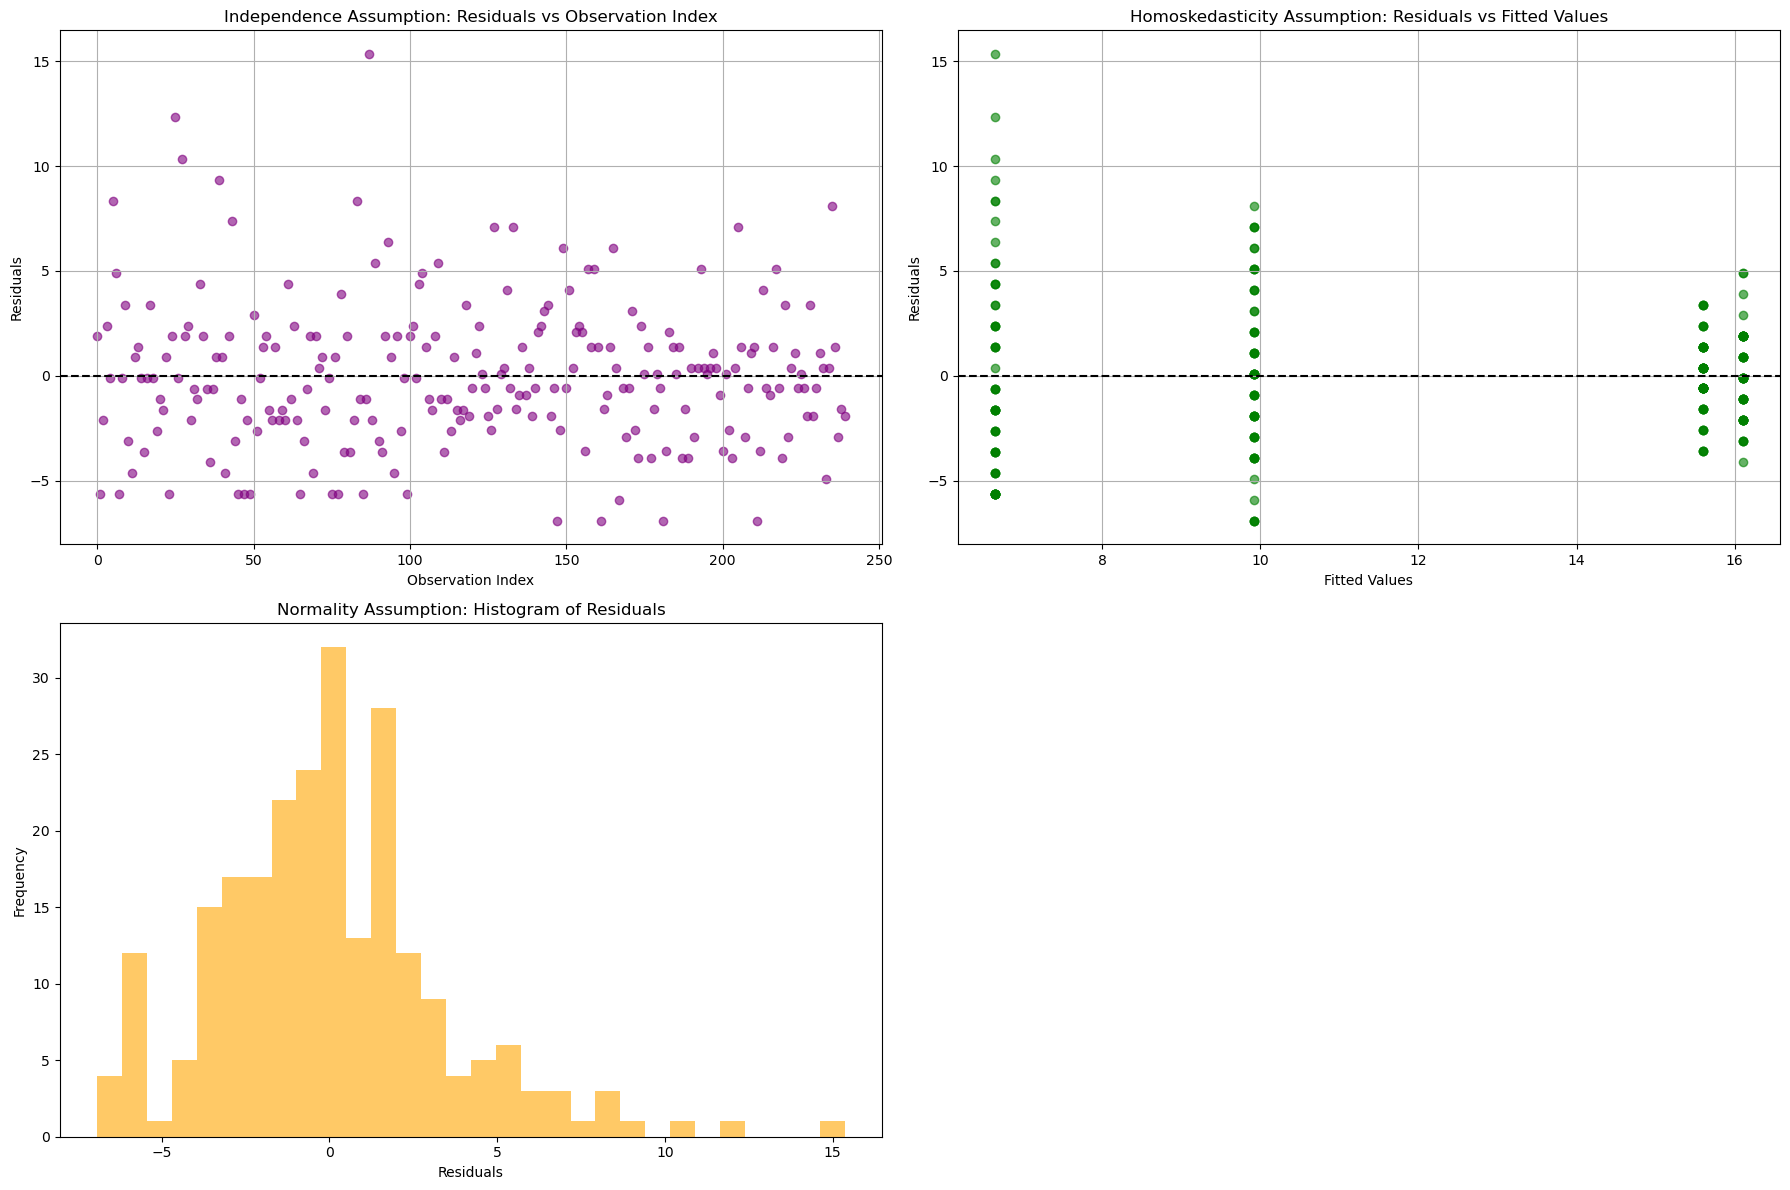


--- Multicollinearity Check (Variance Inflation Factor) ---
          Feature       VIF
1       Treatment  2.033898
2            Post  2.000000
3  Treatment_Post  3.033898


In [62]:

# Fit a simple linear regression model
residuals = model.resid
fitted_values = model.fittedvalues  

plt.figure(figsize=(18, 12))
print("\n--- Check Linear Regression Assumptions ---")

# 1. Independence (Scatter plot of residuals vs observation index)
plt.subplot(2, 2, 1)
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Independence Assumption: Residuals vs Observation Index')
plt.xlabel('Observation Index')
plt.ylabel('Residuals')
plt.grid(True)

# 2. Homoskedasticity (Residuals vs Fitted Values)
plt.subplot(2, 2, 2)
plt.scatter(fitted_values, residuals, color='green', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Homoskedasticity Assumption: Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)

# 3. Normality of Residuals (Histogram)
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, color='orange', alpha=0.6)
plt.title('Normality Assumption: Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Multicollinearity Check
print("\n--- Multicollinearity Check (Variance Inflation Factor) ---")

# Calculating VIF for each independent variable (excluding the constant)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Exclude the constant (intercept) from the VIF results
vif_data = vif_data[vif_data["Feature"] != "const"]
print(vif_data)

In [63]:
normal_price = target[(target['Treatment'] == 1)].describe().loc['max', 'Total Price']
print(normal_price)
disc_price = target[(target['Treatment'] == 1)].describe().loc['min', 'Total Price']
print(disc_price)

target.describe()

23.5
16.34090909090909


,Date,Region,Unit Price,Quantity Ordered,Distance,Delivery Fees,Discount Applied,New Unit Price,Total Price,Treatment,Post,Treatment_Post
count,240,240.00000,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2023-03-01 12:00:00,3.00000,16.0,12.079167,10.000000,4.904687,0.254167,16.926705,16.926705,0.500000,0.508333,0.254167
min,2023-01-01 00:00:00,2.00000,16.0,1.000000,5.000000,2.500000,0.000000,16.119048,16.119048,0.000000,0.000000,0.000000
25%,2023-01-30 18:00:00,2.00000,16.0,8.000000,5.000000,2.500000,0.000000,16.156250,16.156250,0.000000,0.000000,0.000000
50%,2023-03-01 12:00:00,3.00000,16.0,14.000000,10.000000,4.812500,0.000000,16.274621,16.274621,0.500000,1.000000,0.000000
75%,2023-03-31 06:00:00,4.00000,16.0,16.000000,15.000000,7.125000,1.000000,16.890625,16.890625,1.000000,1.000000,1.000000
max,2023-04-30 00:00:00,4.00000,16.0,22.000000,15.000000,7.500000,1.000000,23.500000,23.500000,1.000000,1.000000,1.000000
std,NaN,1.00209,0.0,5.257191,5.010449,2.413372,0.436302,1.601381,1.601381,0.501045,0.500975,0.436302


3.7691025284801456
-0.5264778135019885
nan


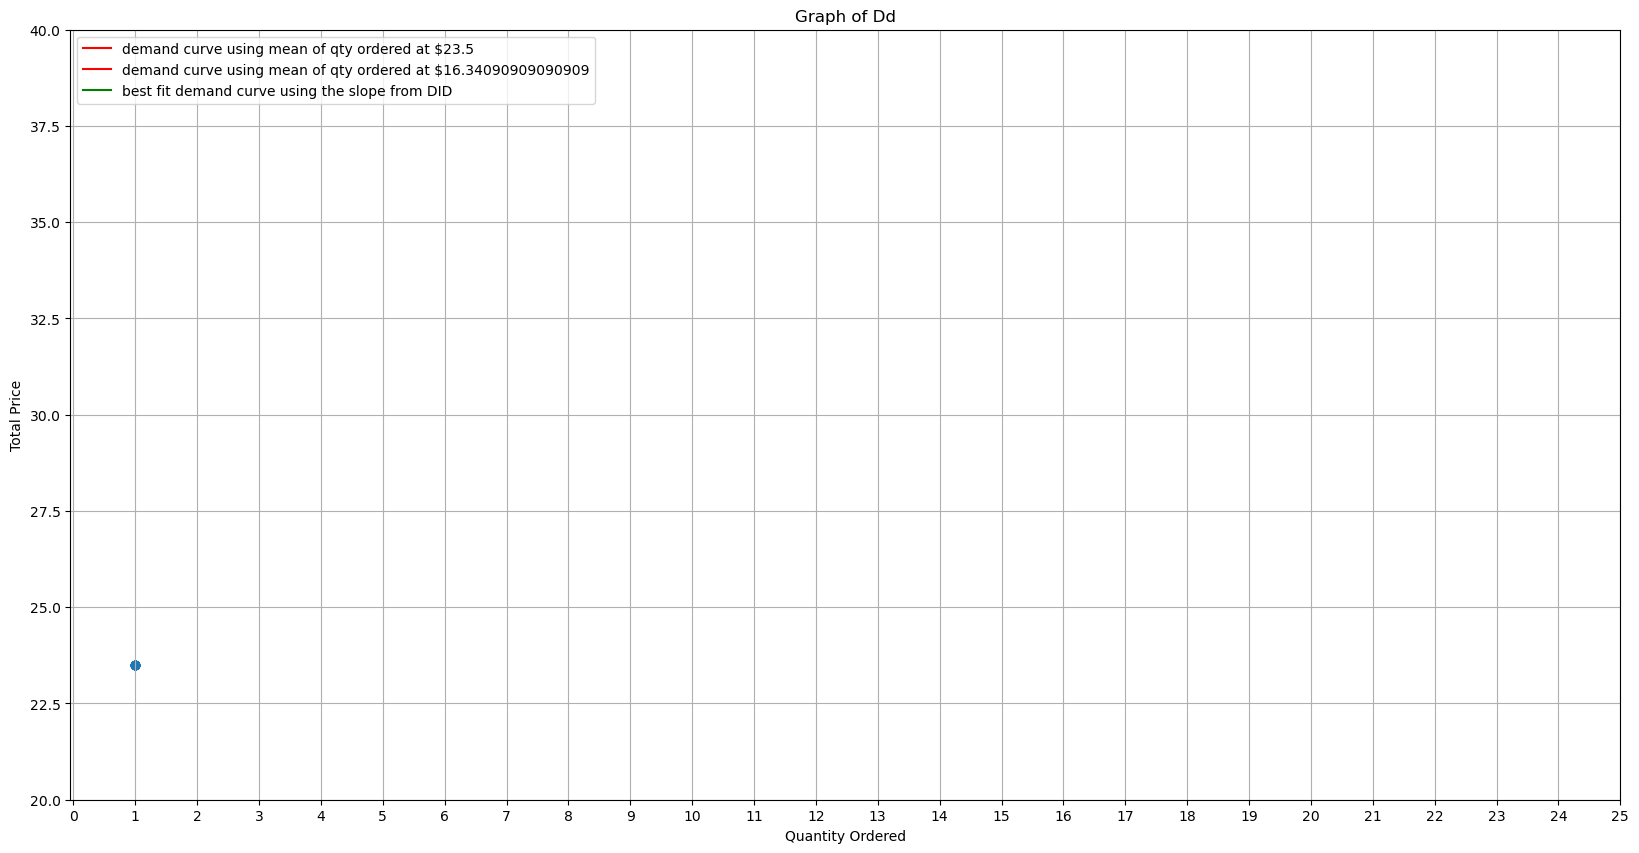

In [64]:
m = model.params.iloc[3]
print(m)

elasticity = m/(disc_price-normal_price)

print(elasticity)

df_region_4_post = df[(df['Region'] == 4) & (df['Unit Price'] + df['Delivery Fees'] == disc_price)]
mean_of_post = df_region_4_post.describe().loc['mean', 'Quantity Ordered']

df_region_4_pre = df[(df['Region'] == 4) & (df['Unit Price'] + df['Delivery Fees'] == normal_price)]
mean_of_pre = df_region_4_post.describe().loc['mean', 'Quantity Ordered']

intercept_1 = elasticity*(mean_of_pre*-1)+normal_price
intercept_2 = elasticity*(mean_of_post*-1)+disc_price

x = np.arange(0, 26, 1)
y_16 = elasticity*x+intercept_1
y_discount = elasticity*x+intercept_2
best_fit = elasticity*x+((intercept_1+intercept_2)/2)
print((intercept_1+intercept_2)/2)

plt.figure(figsize=(20, 10))
plt.plot(x, y_16, '-r', label=f'demand curve using mean of qty ordered at ${normal_price}')
plt.plot(x, y_discount, '-r', label=f'demand curve using mean of qty ordered at ${disc_price}')
plt.plot(x, best_fit, '-g', label='best fit demand curve using the slope from DID')
plt.scatter(df_region_4_pre['Quantity Ordered'], df_region_4_pre['Total Price'])
plt.scatter(df_region_4_post['Quantity Ordered'], df_region_4_post['Total Price'])
plt.ylim(20, 40)
plt.title('Graph of Dd')
plt.xlabel('Quantity Ordered')
plt.ylabel('Total Price')
plt.xticks(np.arange(0, 26, 1))  # Set x-ticks from 0 to 25 with a step of 1
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [65]:
# region 2 vs 3
target = df[df['Region'].isin([2,3])].drop(columns='dow')
target['Region'] = target['Region'].apply(lambda x: 0 if x==2 else 1)
target['Total Price'] = df['Delivery Fees'] + df['Unit Price']
target['region_discount'] = target['Region']*target['Discount Applied']
target.head()

# region 1 vs 3
# target = df[df['Region'].isin([1,3])].drop(columns='dow')
# target['Region'] = target['Region'].apply(lambda x: 0 if x==1 else 1)
# target['region_discount'] = target['Region']*target['Discount Applied']
# target.head()

,Date,Region,Unit Price,Quantity Ordered,Distance,Delivery Fees,Discount Applied,New Unit Price,Total Price,region_discount
1,2023-01-01,0,16.0,18,5,2.5,0,16.138889,18.5,0
2,2023-01-01,1,16.0,10,9,4.5,0,16.450000,20.5,0
5,2023-01-02,0,16.0,14,5,2.5,0,16.178571,18.5,0
6,2023-01-02,1,16.0,7,9,4.5,0,16.642857,20.5,0
9,2023-01-03,0,16.0,16,5,2.5,0,16.156250,18.5,0


In [66]:
# OLS
y=target['Quantity Ordered']
X=target[['Region','Discount Applied','region_discount']]
# X['Date'] = X['Date'].apply(lambda x: int(datetime.strftime(x,'%Y%m%d')))
X = sm.add_constant(X)
model = sm.OLS(endog=y, exog=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Quantity Ordered   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     110.4
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           1.32e-34
Time:                        18:41:55   Log-Likelihood:                -590.84
No. Observations:                 240   AIC:                             1188.
Df Residuals:                     237   BIC:                             1198.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               15.8500      0.261     60.808      0.000      15.336      16.364
Region              -6.4432      0.454    -14.192      0.000      -7.338      -5.549
Discount Applied     3.0917      0.261     11.859      0.000       2.578       3.605
region_discount      3.0917      0.261     11.859      0.000       2.578       3.605
==============================================================================
Omnibus:                        4.716   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                6.394
Skew:                          -0.012   Prob(JB):                       0.0409
Kurtosis:                       3.799   Cond. No.                     2.58e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.59e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


--- Check Linear Regression Assumptions ---


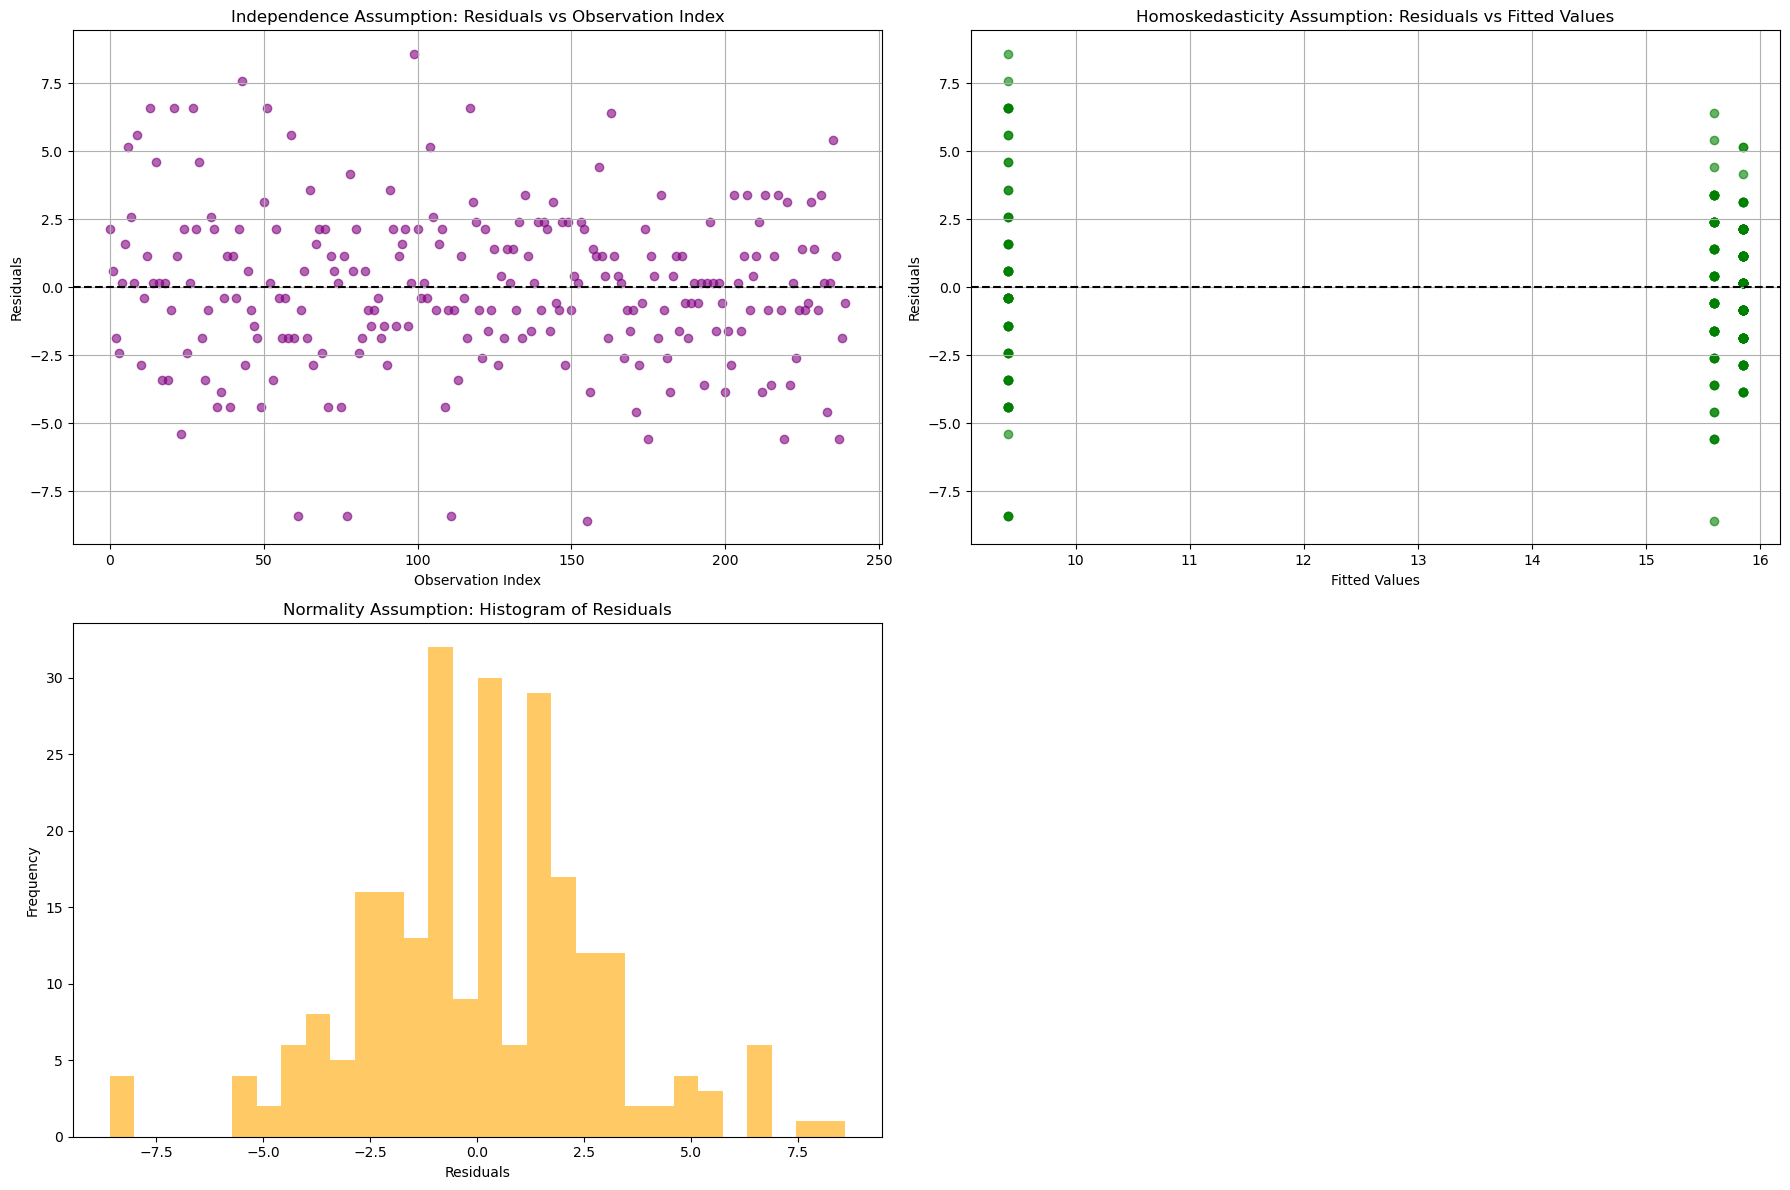


--- Multicollinearity Check (Variance Inflation Factor) ---
            Feature       VIF
1            Region  1.516949
2  Discount Applied       inf
3   region_discount       inf


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [67]:
# Fit a simple linear regression model
residuals = model.resid
fitted_values = model.fittedvalues  

plt.figure(figsize=(18, 12))
print("\n--- Check Linear Regression Assumptions ---")

# 1. Independence (Scatter plot of residuals vs observation index)
plt.subplot(2, 2, 1)
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Independence Assumption: Residuals vs Observation Index')
plt.xlabel('Observation Index')
plt.ylabel('Residuals')
plt.grid(True)

# 2. Homoskedasticity (Residuals vs Fitted Values)
plt.subplot(2, 2, 2)
plt.scatter(fitted_values, residuals, color='green', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Homoskedasticity Assumption: Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)

# 3. Normality of Residuals (Histogram)
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, color='orange', alpha=0.6)
plt.title('Normality Assumption: Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Multicollinearity Check
print("\n--- Multicollinearity Check (Variance Inflation Factor) ---")

# Calculating VIF for each independent variable (excluding the constant)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Exclude the constant (intercept) from the VIF results
vif_data = vif_data[vif_data["Feature"] != "const"]
print(vif_data)

<h3>Use the slope to get the best fit and pass through average</h3>
<p>For a 5% change in price, the quantity demanded changes by 3.09 units</p>

In [68]:
m = model.params.iloc[3]
m

3.091692136704644

<p>To get slope, we need (change in price)/ (change in qty)</p>

In [69]:
# df_reg3_pretreatment = target[(target['Region'] == 1) & (df['Unit Price'] == 16)]
# mean_of_df3_pretreatment = df_reg3_pretreatment.describe().loc['mean', 'Quantity Ordered']
# print(mean_of_df3_pretreatment)

# elasticity = (m/mean_of_df3_pretreatment)/(-5/100)

elasticity = m/(15.2-16)

elasticity

-3.8646151708808016

<p>Now we use the average of the clusters and pass the line through using the elasticity</p>

In [70]:
# df_region_2 = target[target['Region']==0]


# mean_of_16 = df_region_2.describe().loc['mean', 'Quantity Ordered']

In [71]:
df_region_3 = target[(target['Region'] == 1)]
df_region_3_pre = target[(target['Region'] == 1) & (df['Unit Price'] == 15.2)]
df_region_3_post = target[(target['Region'] == 1) & (df['Unit Price'] == 16)]

mean_of_discount_pre = df_region_3_pre.describe().loc['mean', 'Quantity Ordered']
mean_of_discount_post = df_region_3_post.describe().loc['mean', 'Quantity Ordered']

/var/folders/pw/_ml9mkrn07v5x0fngqp4qhg00000gn/T/ipykernel_1512/3407117119.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_region_3_pre = target[(target['Region'] == 1) & (df['Unit Price'] == 15.2)]
/var/folders/pw/_ml9mkrn07v5x0fngqp4qhg00000gn/T/ipykernel_1512/3407117119.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_region_3_post = target[(target['Region'] == 1) & (df['Unit Price'] == 16)]


<p>(y-15.2)=-0.25875797609418427(x-15.59)</p>
<p>y=-0.25876x+19.234</p>

-3.8646151708808016
68.4017837223007


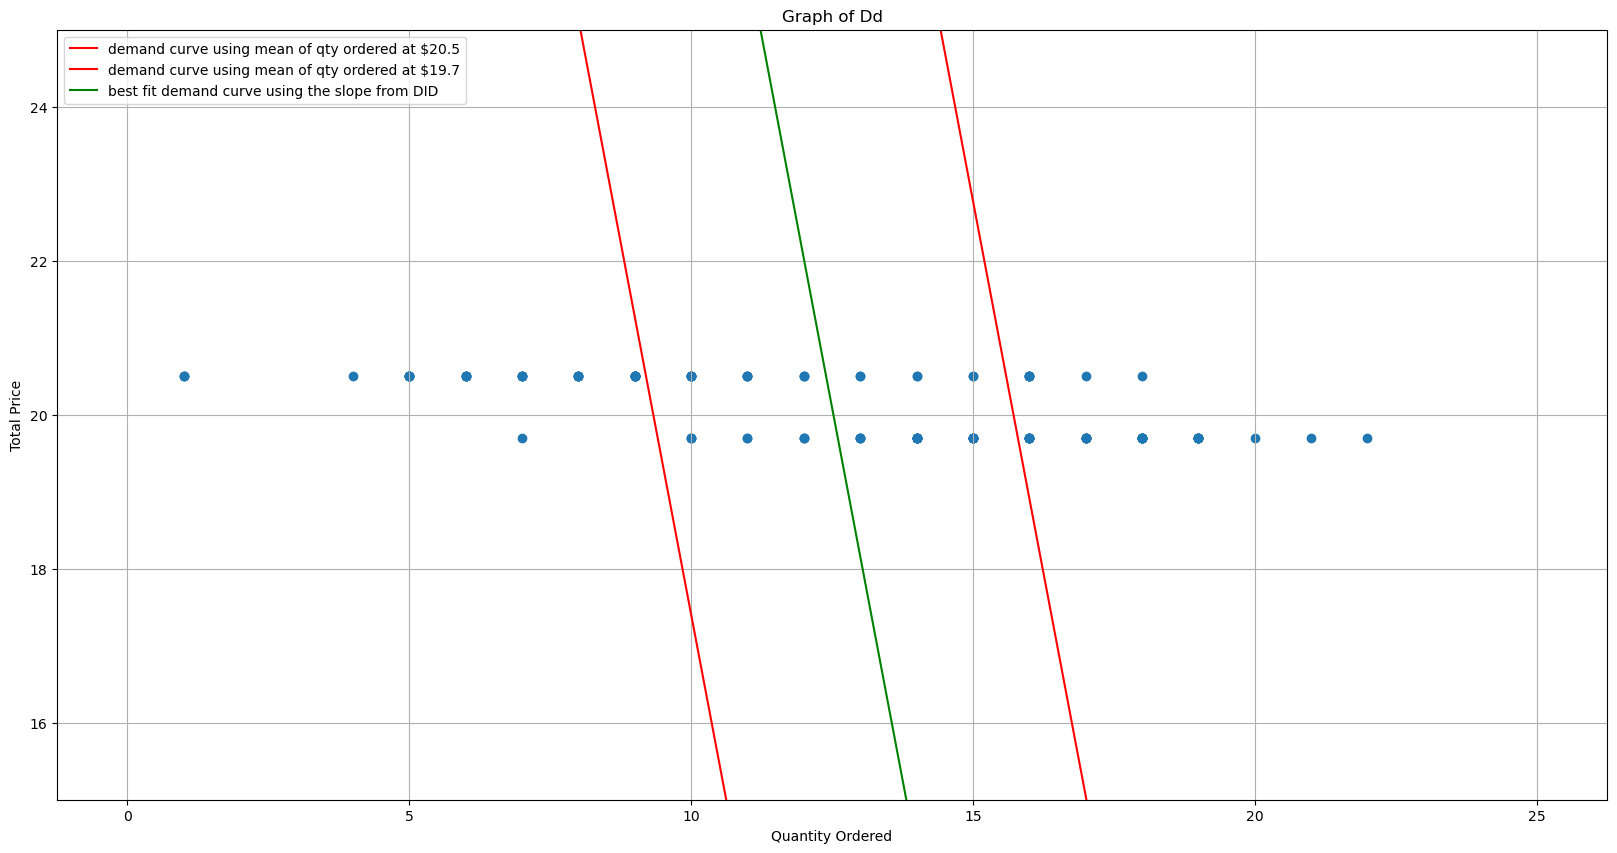

In [72]:
print(f'{elasticity}')
intercept_1 = elasticity*(mean_of_discount_pre*-1)+20.5
intercept_2 = elasticity*(mean_of_discount_post*-1)+19.7

x = np.linspace(0,25,100)
y_16 = elasticity*x+intercept_1
y_discount = elasticity*x+intercept_2
best_fit = elasticity*x+((intercept_1+intercept_2)/2)
print((intercept_1+intercept_2)/2)
plt.figure(figsize=(20, 10))
plt.plot(x, y_16, '-r', label='demand curve using mean of qty ordered at $20.5')
plt.plot(x, y_discount, '-r', label='demand curve using mean of qty ordered at $19.7')
plt.plot(x, best_fit, '-g', label='best fit demand curve using the slope from DID')
# plt.scatter(df_region_2['Quantity Ordered'], df_region_2['Total Price'])
plt.scatter(df_region_3['Quantity Ordered'], df_region_3['Total Price'])
plt.ylim(15,25)
plt.title('Graph of Dd')
plt.xlabel('Quantity Ordered')
plt.ylabel('Total Price')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# TSLS to get the Demand Function

TSLS regression not possible for Region 1 due to: Singular matrix
TSLS regression not possible for Region 2 due to: Singular matrix
TSLS Regression Results for Region 3:
                          IV2SLS Regression Results                           
Dep. Variable:       Quantity Ordered   R-squared:                       0.434
Model:                         IV2SLS   Adj. R-squared:                  0.429
Method:                     Two Stage   F-statistic:                     90.39
                        Least Squares   Prob (F-statistic):           2.95e-16
Date:                Sat, 16 Nov 2024                                         
Time:                        18:41:55                                         
No. Observations:                 120                                         
Df Residuals:                     118                                         
Df Model:                           1                                         
                 coef    std err        

/var/folders/pw/_ml9mkrn07v5x0fngqp4qhg00000gn/T/ipykernel_1512/92162646.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[1].plot(model_tsls.params[0] + model_tsls.params[1] * region_data['Unit Price'], region_data['Unit Price'], color='red', label='Regression Line')


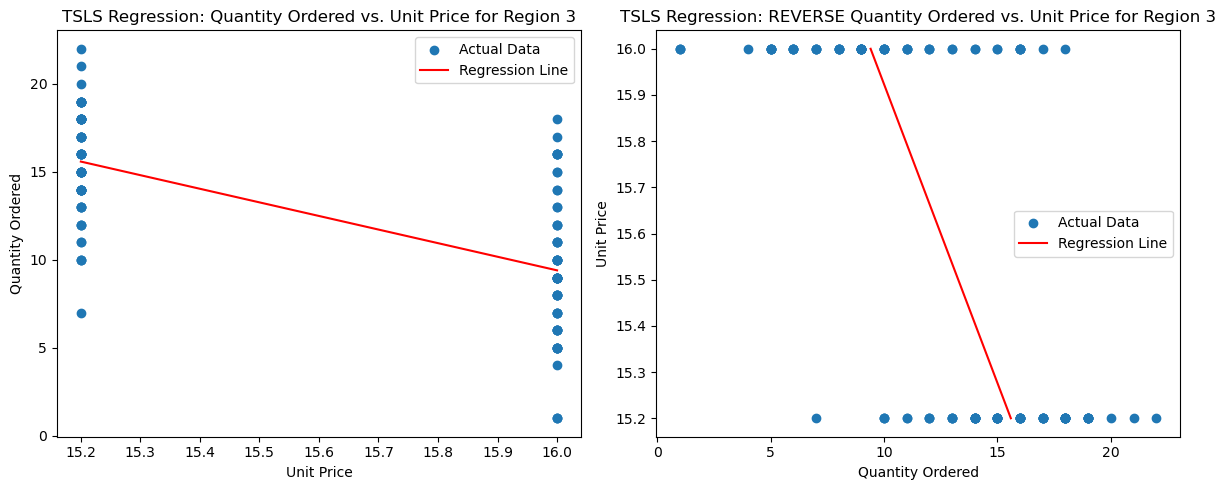

TSLS Regression Results for Region 4:
TSLS regression not possible for Region 4 due to: must have at least one row in constraint matrix


In [73]:
for region_number in df['Region'].unique():
    region_data = df[df['Region'] == region_number]
    
    # Define the dependent and independent variables
    y = region_data['Quantity Ordered']
    X = region_data[['Unit Price']] #, 'Discount Applied'
    Z = region_data[['Distance', 'Discount Applied']]  # Instruments
    
    # Check if there are enough data points to perform TSLS
    if len(region_data) < 3:
        print(f"Not enough data points to perform TSLS for Region {region_number}")
        continue
    
    # Add a constant to the independent variable (intercept)
    X = sm.add_constant(X)
    Z = sm.add_constant(Z)
    
    try:
        # Perform TSLS regression
        model_tsls = IV2SLS(y, X, instrument=Z).fit()
        
        # Print the summary of the regression
        print(f"TSLS Regression Results for Region {region_number}:")
        print(model_tsls.summary())
        print("\n")
        
        # Plot the regression line for regions 3 and 4
        if region_number in [3, 4]:
            fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Adjusted figsize for better visualization
            axs = axs.flatten()
            
            # First plot: Quantity Ordered vs. Unit Price
            axs[0].scatter(region_data['Unit Price'], y, label='Actual Data')
            axs[0].plot(region_data['Unit Price'], model_tsls.predict(X), color='red', label='Regression Line')
            axs[0].set_xlabel('Unit Price')
            axs[0].set_ylabel('Quantity Ordered')
            axs[0].set_title(f'TSLS Regression: Quantity Ordered vs. Unit Price for Region {region_number}')
            axs[0].legend()
            
            # Second plot: REVERSE Quantity Ordered vs. Unit Price
            axs[1].scatter(y, region_data['Unit Price'], label='Actual Data')
            axs[1].plot(model_tsls.params[0] + model_tsls.params[1] * region_data['Unit Price'], region_data['Unit Price'], color='red', label='Regression Line')
            axs[1].set_ylabel('Unit Price')
            axs[1].set_xlabel('Quantity Ordered')
            axs[1].set_title(f'TSLS Regression: REVERSE Quantity Ordered vs. Unit Price for Region {region_number}')
            axs[1].legend()
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"TSLS regression not possible for Region {region_number} due to: {e}")

# Frequency of Quantity Ordered for each region

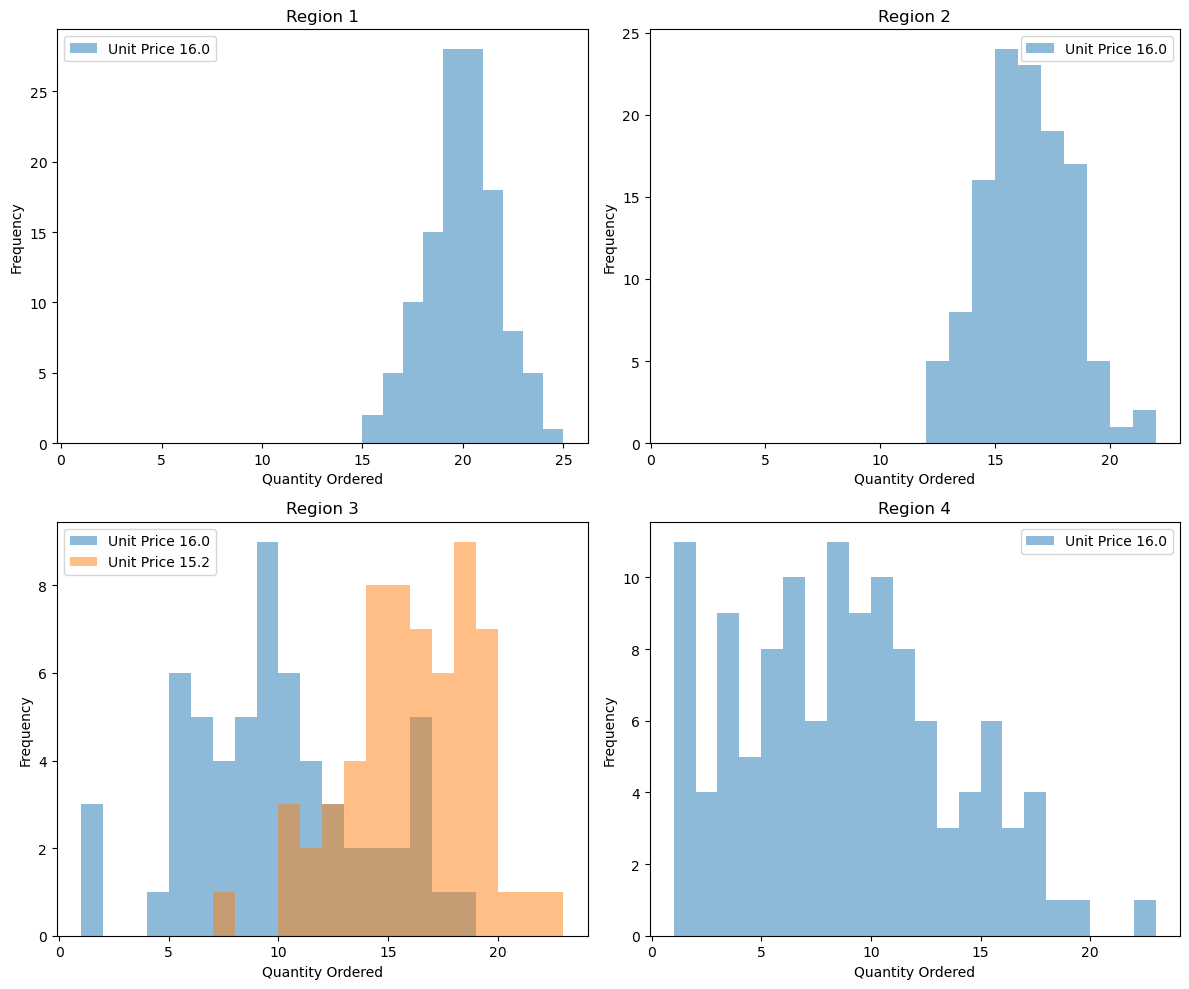

In [74]:
# Create a figure with 4 subplots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot histogram for each region and unit price
for i, region in enumerate(df['Region'].unique()):
    region_data = df[df['Region'] == region]
    for unit_price in region_data['Unit Price'].unique():
        unit_price_data = region_data[region_data['Unit Price'] == unit_price]
        axs[i].hist(unit_price_data['Quantity Ordered'], bins=range(1, unit_price_data['Quantity Ordered'].max() + 2), alpha=0.5, label=f'Unit Price {unit_price}')
    
    axs[i].set_xlabel('Quantity Ordered')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Region {region}')
    axs[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Parallel Trend Assumption Test

In [75]:
# Testing for parallelism assumption using Prof. Keppo's method from his paper
def parallel_assumption_regression(phase_data, dependent_var):
    # Define the independent variables (Treatment, Phase_2, Phase_3, Treatment_Phase_2, Treatment_Phase_3)
    X = phase_data[['Treatment', 'Phase_2', 'Phase_3','Treatment_Phase_1', 'Treatment_Phase_2', 'Treatment_Phase_3']] ##### 
    
    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Define the dependent variable
    y = phase_data[dependent_var]
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Print the summary of the regression
    print(model.summary())


# for trash in trash_type:
#     print(f"Parallel Assumption Regression for {trash}:")
#     results = parallel_assumption_regression(df_3, trash)
#     all_results.append(results)  # Append results to the list

In [76]:
# # Plot Phase 1 data for each contaminant type

# import seaborn as sns

# import statsmodels.api as sm

# # Function to plot and perform linear regression
# def plot_and_regress(df, contaminant, ax):
#     # Filter data for Phase 1
#     phase_1_data = df[df['FirstTrialPhase'] == 1]
    
#     # Plot the data
#     sns.scatterplot(data=phase_1_data, x='Date', y=contaminant, hue='Area', ax=ax)
    
#     # Perform linear regression for UTOWN
#     utown_data = phase_1_data[phase_1_data['Area'] == 'UTOWN']
#     X_utown = sm.add_constant(utown_data['Date'].map(datetime.toordinal))
#     y_utown = utown_data[contaminant]
#     model_utown = sm.OLS(y_utown, X_utown).fit()
#     ax.plot(utown_data['Date'], model_utown.predict(X_utown), color='orange', label='UTOWN Regression')
    
#     # Perform linear regression for ENGINE
#     engine_data = phase_1_data[phase_1_data['Area'] == 'ENGINE']
#     X_engine = sm.add_constant(engine_data['Date'].map(datetime.toordinal))
#     y_engine = engine_data[contaminant]
#     model_engine = sm.OLS(y_engine, X_engine).fit()
#     ax.plot(engine_data['Date'], model_engine.predict(X_engine), color='blue', label='ENGINE Regression')
    
#     # Set plot title and labels
#     ax.set_title(f'{contaminant} Levels in Phase 1')
#     ax.set_xlabel('Date')
#     ax.set_ylabel(f'{contaminant} Level')
#     ax.legend()
#     ax.tick_params(axis='x', rotation=90)

#     return model_utown, model_engine

# # Create subplots for each contaminant type
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # Plot and regress for each contaminant type
# models = []
# for i, contaminant in enumerate(contaminant_types):
#     model_utown, model_engine = plot_and_regress(df_3, contaminant, axs[i])
#     models.append((model_utown, model_engine))

# plt.tight_layout()
# plt.show()

# # Print the regression summaries
# #for i, contaminant in enumerate(contaminant_types):
# #    print(f"\nUTOWN Regression Summary for {contaminant}:")
# #    print(models[i][0].summary())
# #    print(f"\nENGINE Regression Summary for {contaminant}:")
# #    print(models[i][1].summary())

# add control variable

In [77]:
# df_2['weekend'] = df_2['dow'].apply(lambda x: 1 if x in ['Sunday','Saturday'] else 0 )

In [78]:
# def perform_regression_2(phase_data, dependent_var, trash, case):
#     '''
#     include sunday as control variable
#     '''
#     # Define the independent variables (Treatment, Post, Treatment_Post)
#     X = phase_data[['Treatment', 'Phase_2', 'Phase_3', 'Treatment_Phase_2', 'Treatment_Phase_3','weekend']]
    
#     # Add a constant (intercept) to the independent variables
#     X = sm.add_constant(X)
    
#     # Define the dependent variable
#     y = phase_data[dependent_var]
    
#     # Fit the regression model
#     model = sm.OLS(y, X).fit()

#     results = pd.DataFrame({
#         'Case': case,
#         'Phase&Trash': trash,
#         'Variable': model.params.index,
#         'Coefficient': model.params.values,
#         'P-value': model.pvalues.values
        
#     })
    
#     # Print the summary of the regression
#     print(model.summary())
    
#     return results

In [79]:
# new_results = []
# trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

# for trash in trash_type:
#     print(f"Regression for {trash}:")
#     results = perform_regression_2(df_2, trash, f"{trash}", case = "Case 2")
#     new_results.append(results)  # Append results to the list

# new_results = pd.concat(new_results, ignore_index=True)

In [80]:
# check = pd.merge(final_results, new_results, on=['Case','Phase&Trash','Variable'], suffixes=['_before','_after'])

In [81]:
# # weekend p-value check
# new_results[new_results['Variable']=='weekend']

In [82]:
# # sensitivity check -> almost no change in coefficient_before(no control variable) vs coefficient_after(add control variable)
# diff = check[(check.Variable=='Treatment_Phase_2') |(check.Variable=='Treatment_Phase_3')][['Case','Phase&Trash','Variable','Coefficient_before','Coefficient_after','P-value_before','P-value_after']]
# diff

In [83]:
# diff.to_excel('sensitivity.xlsx')

<!-- # placebo  -->

In [84]:
# fake_date = df_2[df_2['FirstTrialPhase']==1]['Date'].median()
# phase1_end = datetime(2020, 2, 9)
# fake_date

In [85]:
# df_4 = df_2.copy()
# max(df_4.Date)

In [86]:
# def perform_regression(phase_data, dependent_var, trash, case):
#     # Define the independent variables (Treatment, Post, Treatment_Post)
#     X = phase_data[['Treatment', 'Phase_2', 'Treatment_Phase_2']]
    
#     # Add a constant (intercept) to the independent variables
#     X = sm.add_constant(X)
    
#     # Define the dependent variable
#     y = phase_data[dependent_var]
    
#     # Fit the regression model
#     model = sm.OLS(y, X).fit()

#     results = pd.DataFrame({
#         'Case': case,
#         'Phase&Trash': trash,
#         'Variable': model.params.index,
#         'Coefficient': model.params.values,
#         'P-value': model.pvalues.values
#     })
    
#     # Print the summary of the regression
#     print(model.summary())


#     return results

In [87]:
# # preprocessing

# # Adding a new column 'Treatment' that returns 1 when Area is UTOWN and 0 when Area is ENGINE
# df_4['Treatment'] = df_4['Area'].apply(lambda x: 1 if x == 'UTOWN' else 0)

# # Adding two new columns 'Phase_2' and 'Phase_3'
# df_4['Phase_1'] = df_4['Date'].apply(lambda x: 1 if x <= fake_date else 0) ####### ADDED FOR PARALLELISM TEST
# df_4['Phase_2'] = df_4['Date'].apply(lambda x: 1 if (x > fake_date) & (x < phase1_end) else 0)
# # df_4['Phase_3'] = df_4['FirstTrialPhase'].apply(lambda x: 1 if x == 3 else 0)

# # Adding a new column 'Treatment_Post' which is the product of 'Treatment' and 'Phase' columns
# df_4['Treatment_Phase_1'] = df_4['Treatment'] * df_4['Phase_1'] ####### ADDED FOR PARALLELISM TEST
# df_4['Treatment_Phase_2'] = df_4['Treatment'] * df_4['Phase_2']

In [88]:
# all_results = []
# trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

# for trash in trash_type:
#     print(f"Regression for {trash}:")
#     results = perform_regression(df_4, trash, f"{trash}", case = "Case 2")
#     all_results.append(results)  # Append results to the list

# # Concatenate all results into a single DataFrame
# final_results = pd.concat(all_results, ignore_index=True)

In [89]:
# final_results['P-value'] = final_results['P-value'].apply(lambda x: round(x, 5))

In [90]:
# final_results[final_results.Variable=='Treatment_Phase_2']

# Plots: Quantity Ordered vs. Unit Price

TSLS Regression Results:
                          IV2SLS Regression Results                           
Dep. Variable:       Quantity Ordered   R-squared:                      -0.008
Model:                         IV2SLS   Adj. R-squared:                 -0.011
Method:                     Two Stage   F-statistic:                     14.85
                        Least Squares   Prob (F-statistic):           0.000133
Date:                Sat, 16 Nov 2024                                         
Time:                        18:41:55                                         
No. Observations:                 480                                         
Df Residuals:                     478                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.5180     2

/var/folders/pw/_ml9mkrn07v5x0fngqp4qhg00000gn/T/ipykernel_1512/3272135064.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(model.params[0] + model.params[1] * df['Unit Price'], df['Unit Price'], color='red', label='Regression Line')


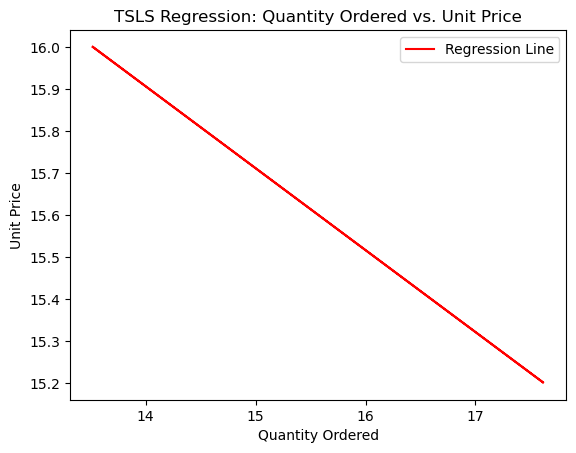

Regression Coefficients:
const         95.518000
Unit Price    -5.124835
dtype: float64


In [91]:
# Define the dependent and independent variables
y = df['Quantity Ordered']
X = df[['Unit Price']] #, 'Discount Applied'
Z = df[['Distance', 'Discount Applied']]  # Instruments

# Add a constant to the independent variable (intercept)
X = sm.add_constant(X)
Z = sm.add_constant(Z)

# Perform TSLS regression
model = IV2SLS(y, X, instrument=Z).fit()

# Print the summary of the regression
print("TSLS Regression Results:")
print(model.summary())
# print("\n")

# Plot X vs Y and add the regression line from the IV2SLS regression
#plt.scatter(y, df['Unit Price'], label='Actual Data')
plt.plot(model.params[0] + model.params[1] * df['Unit Price'], df['Unit Price'], color='red', label='Regression Line')
plt.ylabel('Unit Price')
plt.xlabel('Quantity Ordered')
plt.title('TSLS Regression: Quantity Ordered vs. Unit Price')
plt.legend()
plt.show()
# Plot X vs Y and add the regression line from the IV2SLS regression
# plt.scatter(df['Unit Price'], y, label='Actual Data')
# plt.plot(df['Unit Price'], model.params[0] + model.params[1]x, color='red', label='Regression Line')
# plt.xlabel('Unit Price')
# plt.ylabel('Quantity Ordered')
# plt.title('TSLS Regression: Quantity Ordered vs. Unit Price')
# plt.legend()
# plt.show()

# Plot the TSLS redisuals
#plt.scatter(y, model.predict())
#plt.xlabel('Actual Quantity Ordered')
#plt.ylabel('Predicted Quantity Ordered')
#plt.title('TSLS Regression Results')
#plt.show()

# Print the regression coefficients
print("Regression Coefficients:")
print(model.params)

In [92]:
print(model.params[0])

95.51800038794346


/var/folders/pw/_ml9mkrn07v5x0fngqp4qhg00000gn/T/ipykernel_1512/4214041344.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(model.params[0])


TSLS Regression Results (using OLS):
                            OLS Regression Results                            
Dep. Variable:       Quantity Ordered   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     15.45
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           9.70e-05
Time:                        18:41:56   Log-Likelihood:                -1488.8
No. Observations:                 480   AIC:                             2982.
Df Residuals:                     478   BIC:                             2990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         9

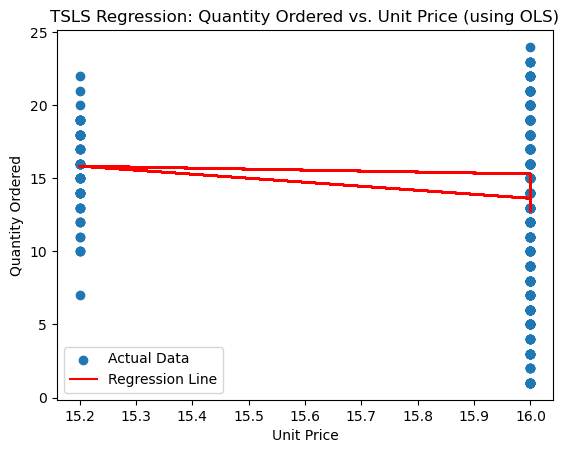

In [93]:
from sklearn.linear_model import LinearRegression

# First stage: Regress the endogenous variable (Unit Price) on the instruments (Distance and Discount Applied)
first_stage_model = LinearRegression()
first_stage_model.fit(Z, X['Unit Price'])
X_hat = first_stage_model.predict(Z)

# Add a constant to the predicted values
X_hat = sm.add_constant(X_hat)

# Second stage: Regress the dependent variable (Quantity Ordered) on the predicted values from the first stage
second_stage_model = sm.OLS(y, X_hat).fit()

# Print the summary of the regression
print("TSLS Regression Results (using OLS):")
print(second_stage_model.summary())

# Plot the regression line
plt.scatter(df['Unit Price'], y, label='Actual Data')
plt.plot(df['Unit Price'], second_stage_model.predict(X_hat), color='red', label='Regression Line')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Ordered')
plt.title('TSLS Regression: Quantity Ordered vs. Unit Price (using OLS)')
plt.legend()
plt.show()

Perform a two stage least squares with Y (Dependent Variable) as 'Quantity Ordered', X (dependent varialble) as 'Unit Price' and  use 'Discount Applied' as the controll variable. 'Discount Applied' and 'Distance' are the instrumental variables